In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm.notebook import tqdm

In [2]:
sns.set("notebook", style="white")

### Height and gravity

In [3]:
delta_t = 2
x_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
x_plot = np.linspace(-2, 2, 1000)

In [4]:
def height(x):
    
    if x <= 0:
        y = x**2 + x + 0.25
    else:
        y = x*(1+5*x**2)**(-1/2) + (1/32)*(x**4) + 0.25
    
    return y

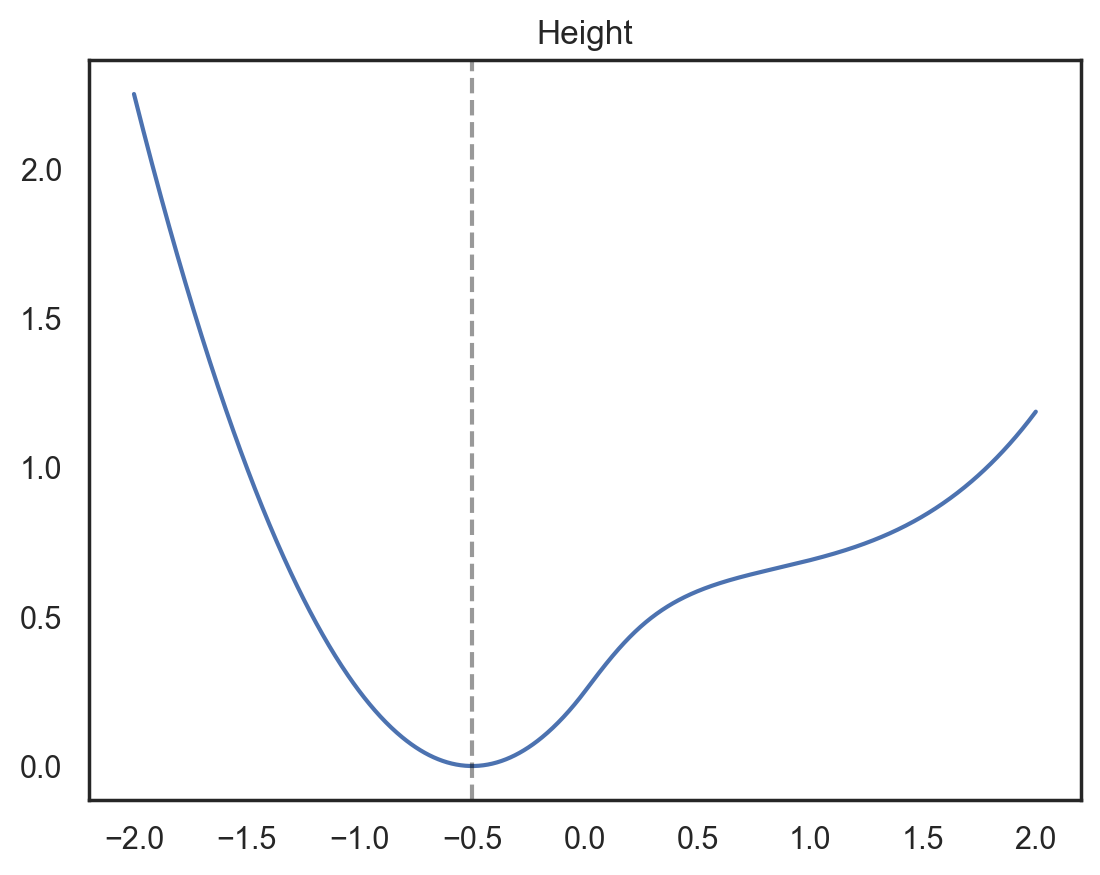

In [5]:
fig, ax = plt.subplots()
ax.plot(x_plot, [height(x) for x in x_plot])
ax.set_title("Height")
ax.axvline(-0.5, linestyle="--", color="black", alpha=0.4);

In [328]:
def phi(x):
    phi = np.zeros_like(x)
    is_leq0 = x<=0
    phi_1 = 2*x+1
    a = (1 + 5*x**2)
    phi_2 = a**(-0.5)
    phi_3 = - 5*x**2*a**(-1.5)
    phi_4 = (x/2)**4 # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]  
    return - phi
#     if x <= 0:
#         return -2*x - 1
#     else:
#         return # (1+5*x**2)**(-1/2)- 5*x**2*(1+5*x**2)**(-3/2) + 0.5*x**4 
#         # -(1+5*x**2)**(-3/2) - (1/8)*x**3

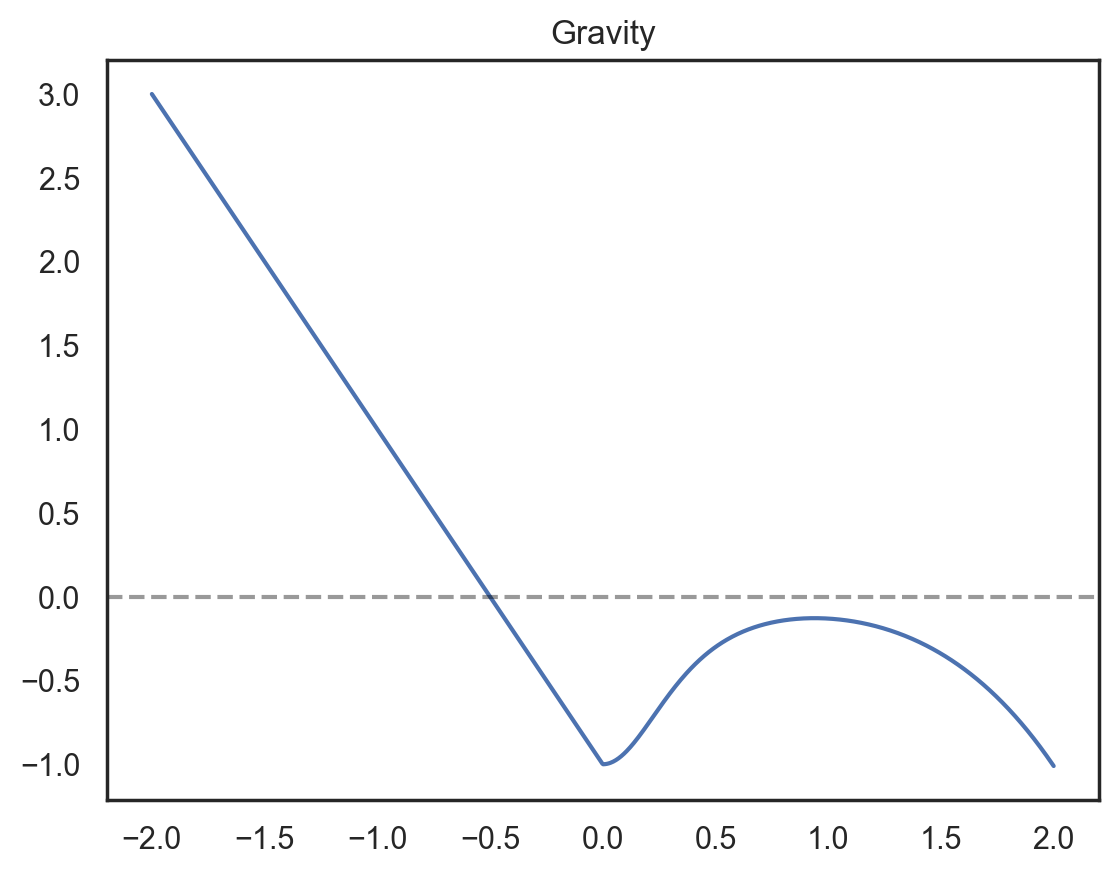

In [329]:
fig, ax = plt.subplots()
ax.plot(x_plot, phi(x_plot))
ax.axhline(0, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gravity");

In [8]:
actions = np.arange(-2, 3)
actions

array([-2, -1,  0,  1,  2])

In [9]:
def update_position_and_velocity(position, velocity, action):
    force_action = np.tanh(action)
    force_friction = -(1/8) * velocity
    force_gravity = phi(position)
    force = force_gravity + force_friction + force_action
    velocity += force
    position += velocity
    return position, velocity

In [10]:
position, velocity = (-2.0, 0.0)
update_position_and_velocity(position, velocity, 0)

(1.0, 3.0)

In [11]:
position, velocity = update_position_and_velocity(position, velocity, 2)
position, velocity

(1.964027580075817, 3.964027580075817)

## Gym

In [12]:
import gym

In [13]:
env = gym.make("MountainCar-v0")

In [14]:
env.reset()

array([-0.47754338,  0.        ], dtype=float32)

In [15]:
env.step(2)

(array([-0.4768877 ,  0.00065568], dtype=float32), -1.0, False, {})

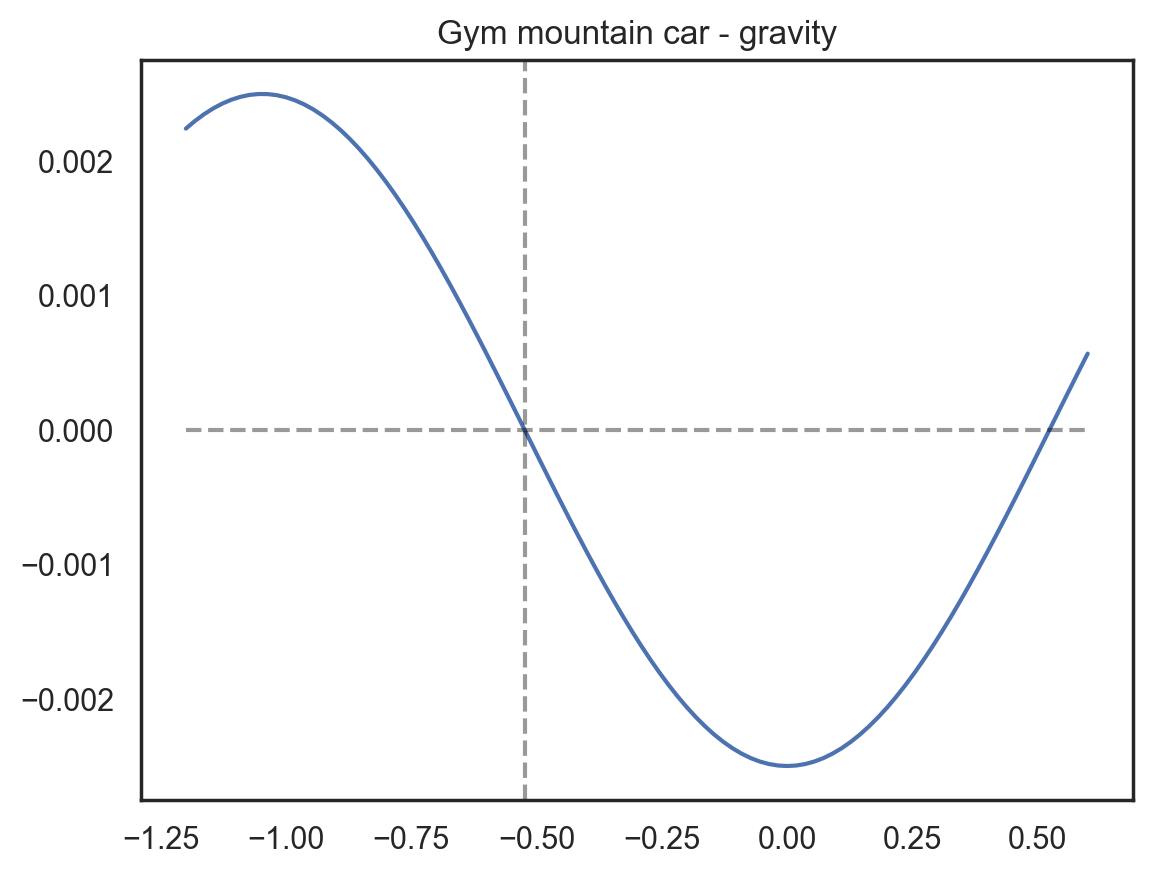

In [16]:
x_gym = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots()
ax.plot(x_gym, -0.0025 * np.cos(3*x_gym))
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.hlines(0., xmin=x_gym[0], xmax=x_gym[-1], linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - gravity");

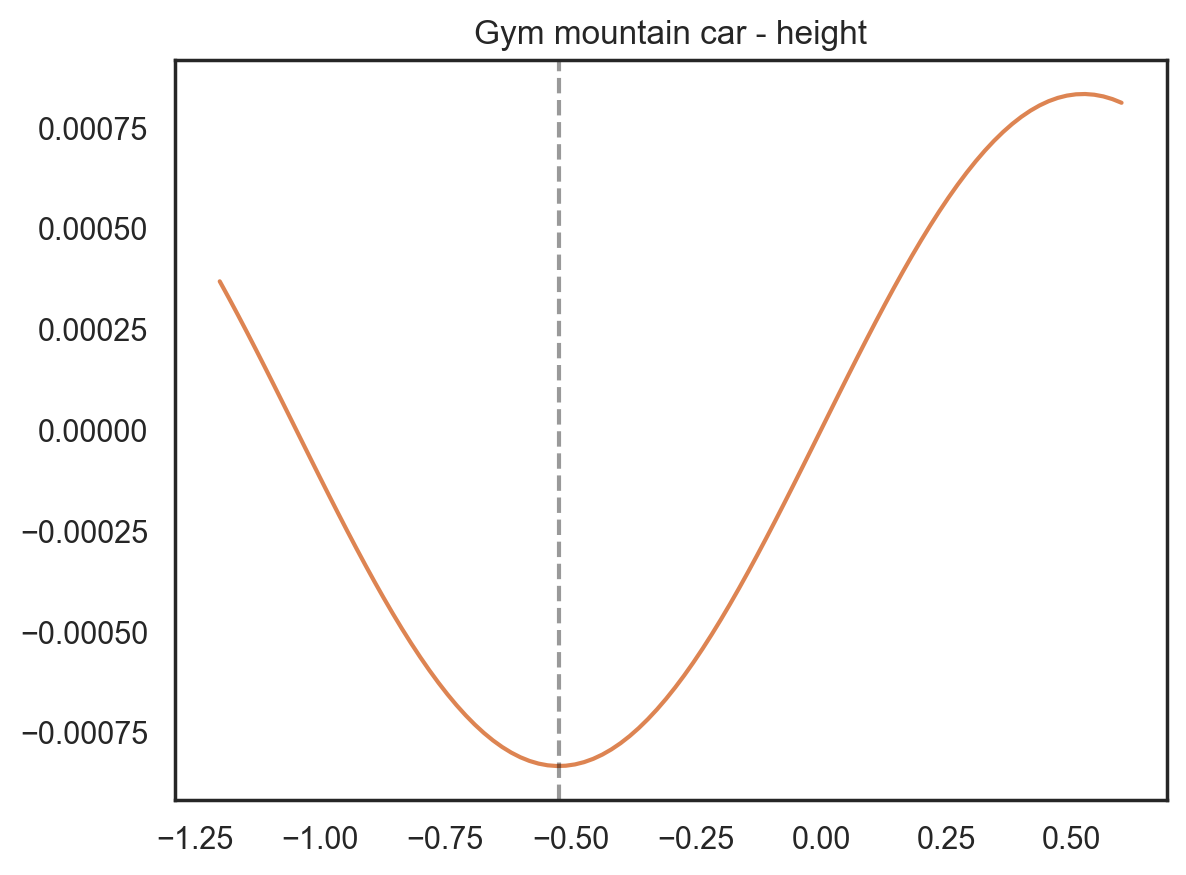

In [17]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200, color="C1")
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - height");

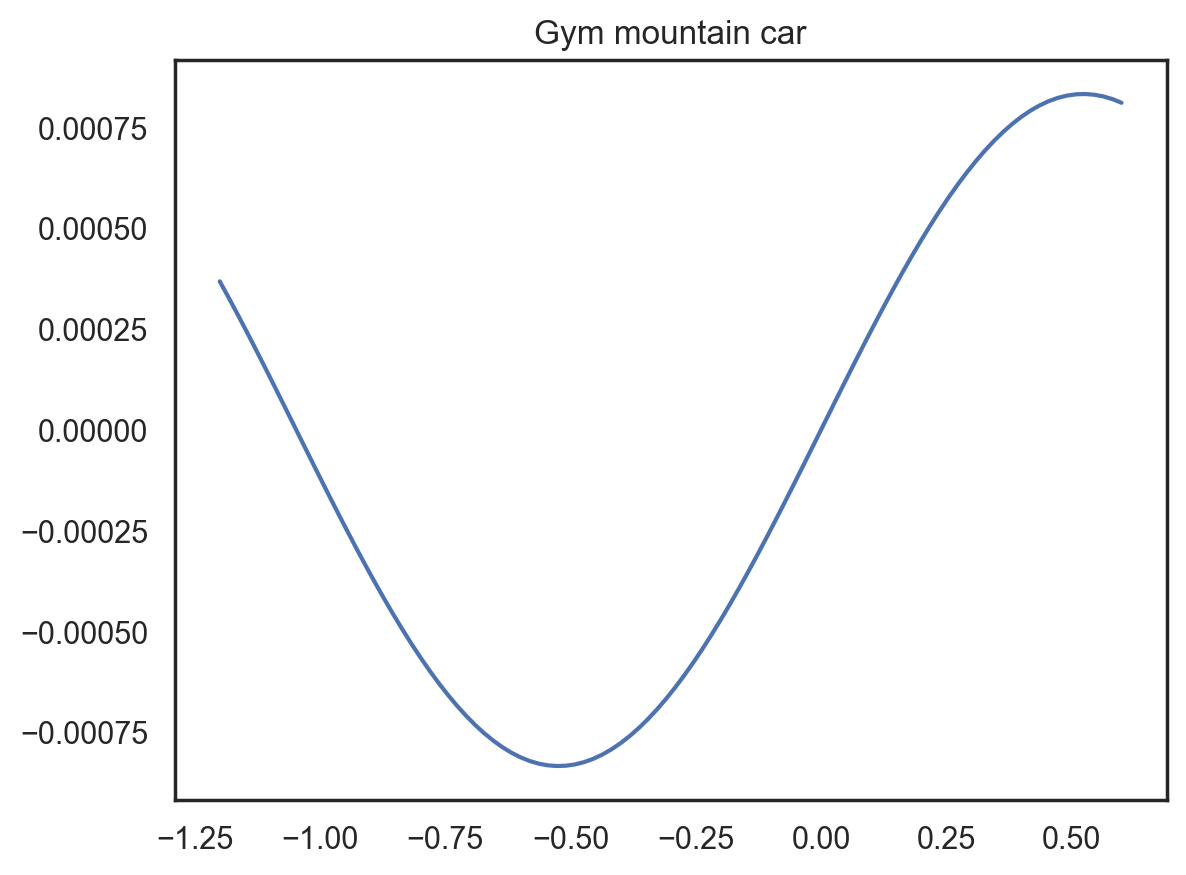

In [18]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200)
ax.set_title("Gym mountain car");

In [19]:
def dynamics_gym(position, velocity, action, gravity=0.0025, force=0.001):
    assert action in [-1, 0, 1], "Action needs to be either -1, 0, or 1"
    velocity += action*force - np.cos(3 * position) * gravity
    position += velocity
    return position, velocity

In [20]:
position, velocity = -np.pi/6, 0
actions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
for i, action in enumerate(actions):
    position, velocity = dynamics_gym(position, velocity, action)
    velocity = np.clip(velocity, -0.07, 0.07)
    position = np.clip(position, -1.2, 0.6)
    print(i, action, position, velocity)

0 1 -0.5225987755982988 0.0009999999999999998
1 1 -0.5206062755870489 0.0019925000112499943
2 1 -0.5176362190244069 0.0029700565626419734
3 1 -0.5137108792513178 0.003925339773089185
4 1 -0.5088596878254337 0.004851191425884095
5 1 -0.5031190035396563 0.00574068428577737
6 1 -0.4965318209290182 0.006587182610638135
7 1 -0.48914741746676027 0.007384403462257964
8 1 -0.4810209394215762 0.008126478045184092
9 1 -0.47221292748890664 0.00880801193266958


## Backward motion

#### Old motion Implementation

In [21]:
# def forward_motion(motion, action, delta_t, scale_gravity, scale_friction):
    
#     def _equations_of_motion(t, x, *args):
#         action,  = args
#         position, velocity = x

#         force_action = np.tanh(action)

#         force_friction = -scale_friction * velocity

#         if position <= 0:
#             force_gravity = -2*position - 1
#         else:
#             # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
#             force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

#         force_gravity *= scale_gravity # Scale it

#         force = force_gravity + force_friction + force_action
#         change_in_velocity = force
#         change_in_position = velocity
        
#         if (velocity >= 3 and change_in_velocity > 0) \
#                 or (velocity <= -3 and change_in_velocity < 0):
#             change_in_velocity = 0
        
#         if (position <= -2 and change_in_position < 0) \
#                 or (position >= 2 and change_in_position > 0):
#             change_in_position = 0
#             change_in_velocity = - velocity # zeroing out velocity
            
#         dy = np.array([change_in_position, change_in_velocity])
#         return dy
    
# #     def _bounds(t, y):
# #         position, velocity = y.reshape((2,))
# #         if position <= -2 or position >=2 or velocity <= -3 or velocity >= 3
# #             return True
# #         else:
# #             return False
    
#     sol = scipy.integrate.solve_ivp(
#         fun=_equations_of_motion, 
#         y0=motion,
#         args=(action, ), 
#         t_span=[0, delta_t, ],
#         t_eval=[delta_t, ])
#         # events=_bounds)
    
#     position, velocity =  sol.y.reshape((2,))
#     position = np.clip(position, -2, 2)
#     velocity = np.clip(velocity, -3, 3)
#     return np.array([position, velocity])

#### New implementation

In [22]:
def plot_belief(b, fig=None, ax=None, colorbar=True, colormap="gray"):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    pos = ax.imshow(
        b.reshape(len(position_space), len(velocity_space)), 
        origin="lower", 
        extent=(min(position_space), max(position_space),
                min(velocity_space), max(velocity_space)),
        aspect=(max(position_space)-min(position_space)) 
            /(max(velocity_space)-min(velocity_space)),
        cmap=colormap)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    if colorbar:
        fig.colorbar(pos)

In [335]:
delta_t = 1.
scale_gravity = 0.44
scale_friction = 0.25 # 0.04 # 0.125 # 1/8
scale_action = 0.25
scale_position = 0.5
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

In [336]:
def forward_motion(motion, action, delta_t, 
                   scale_gravity, scale_friction, scale_action, scale_position):
    
    position, velocity = motion

    force_action = scale_action * np.tanh(action)

    force_friction = -scale_friction * velocity

    if position <= 0:
        force_gravity = -2*position - 1
    else:
        a = (1 + 5*position**2)
        phi_2 = a**(-0.5)
        phi_3 = - 5*position**2*a**(-1.5)
        phi_4 = (position/2)**4 # negative of paper
        phi = phi_2 + phi_3 + phi_4
        # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
        # force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3
        force_gravity = -phi
        
    force_gravity *= scale_gravity # Scale it

    force = force_gravity + force_friction + force_action
    change_in_velocity = force
    change_in_position = scale_position*velocity

    if (velocity >= 3 and change_in_velocity > 0) \
            or (velocity <= -3 and change_in_velocity < 0):
        change_in_velocity = 0

    if (position <= -2 and change_in_position < 0) \
            or (position >= 2 and change_in_position > 0):
        change_in_position = 0
        change_in_velocity = - velocity # zeroing out velocity
    
    position += change_in_position
    velocity += change_in_velocity
    
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

In [337]:
coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)   

p = np.zeros((n_action, n_state, n_state))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(n_action):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t,
            scale_gravity=scale_gravity,
            scale_friction=scale_friction,
            scale_action=scale_action,
            scale_position=scale_position)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(n_state)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p[idx_act, idx, :] =  s
        p[idx_act, idx, :] /= p[idx_act, idx, :].sum()

In [338]:
p_backward = np.zeros_like(p)
for idx_act in range(n_action):
    p_backward[idx_act] = p[idx_act]
    for idx in range(n_state):
        bwd_sum = p_backward[idx_act, :, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, :, idx] /= bwd_sum # Normalize

In [339]:
n_steps_variations = [0, 4, 8]

belief_plot = np.zeros((n_action, len(n_steps_variations), n_state))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    belief = np.zeros(n_state)
    dist, idx = tree.query(starting_motion)
    belief[idx] = 1

    step = 0
    for step in range(n_steps_variations[-1]+1):
        if step in n_steps_variations:
            belief_plot[idx_act, n_steps_variations.index(step), :] = belief

#         new_b = np.zeros_like(b)
#         for idx_future in range(state_space_size):
#             for idx_past in range(state_space_size):
#                 new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_past, idx_future]

        belief = np.dot(p_backward[idx_act], belief)
        step += 1

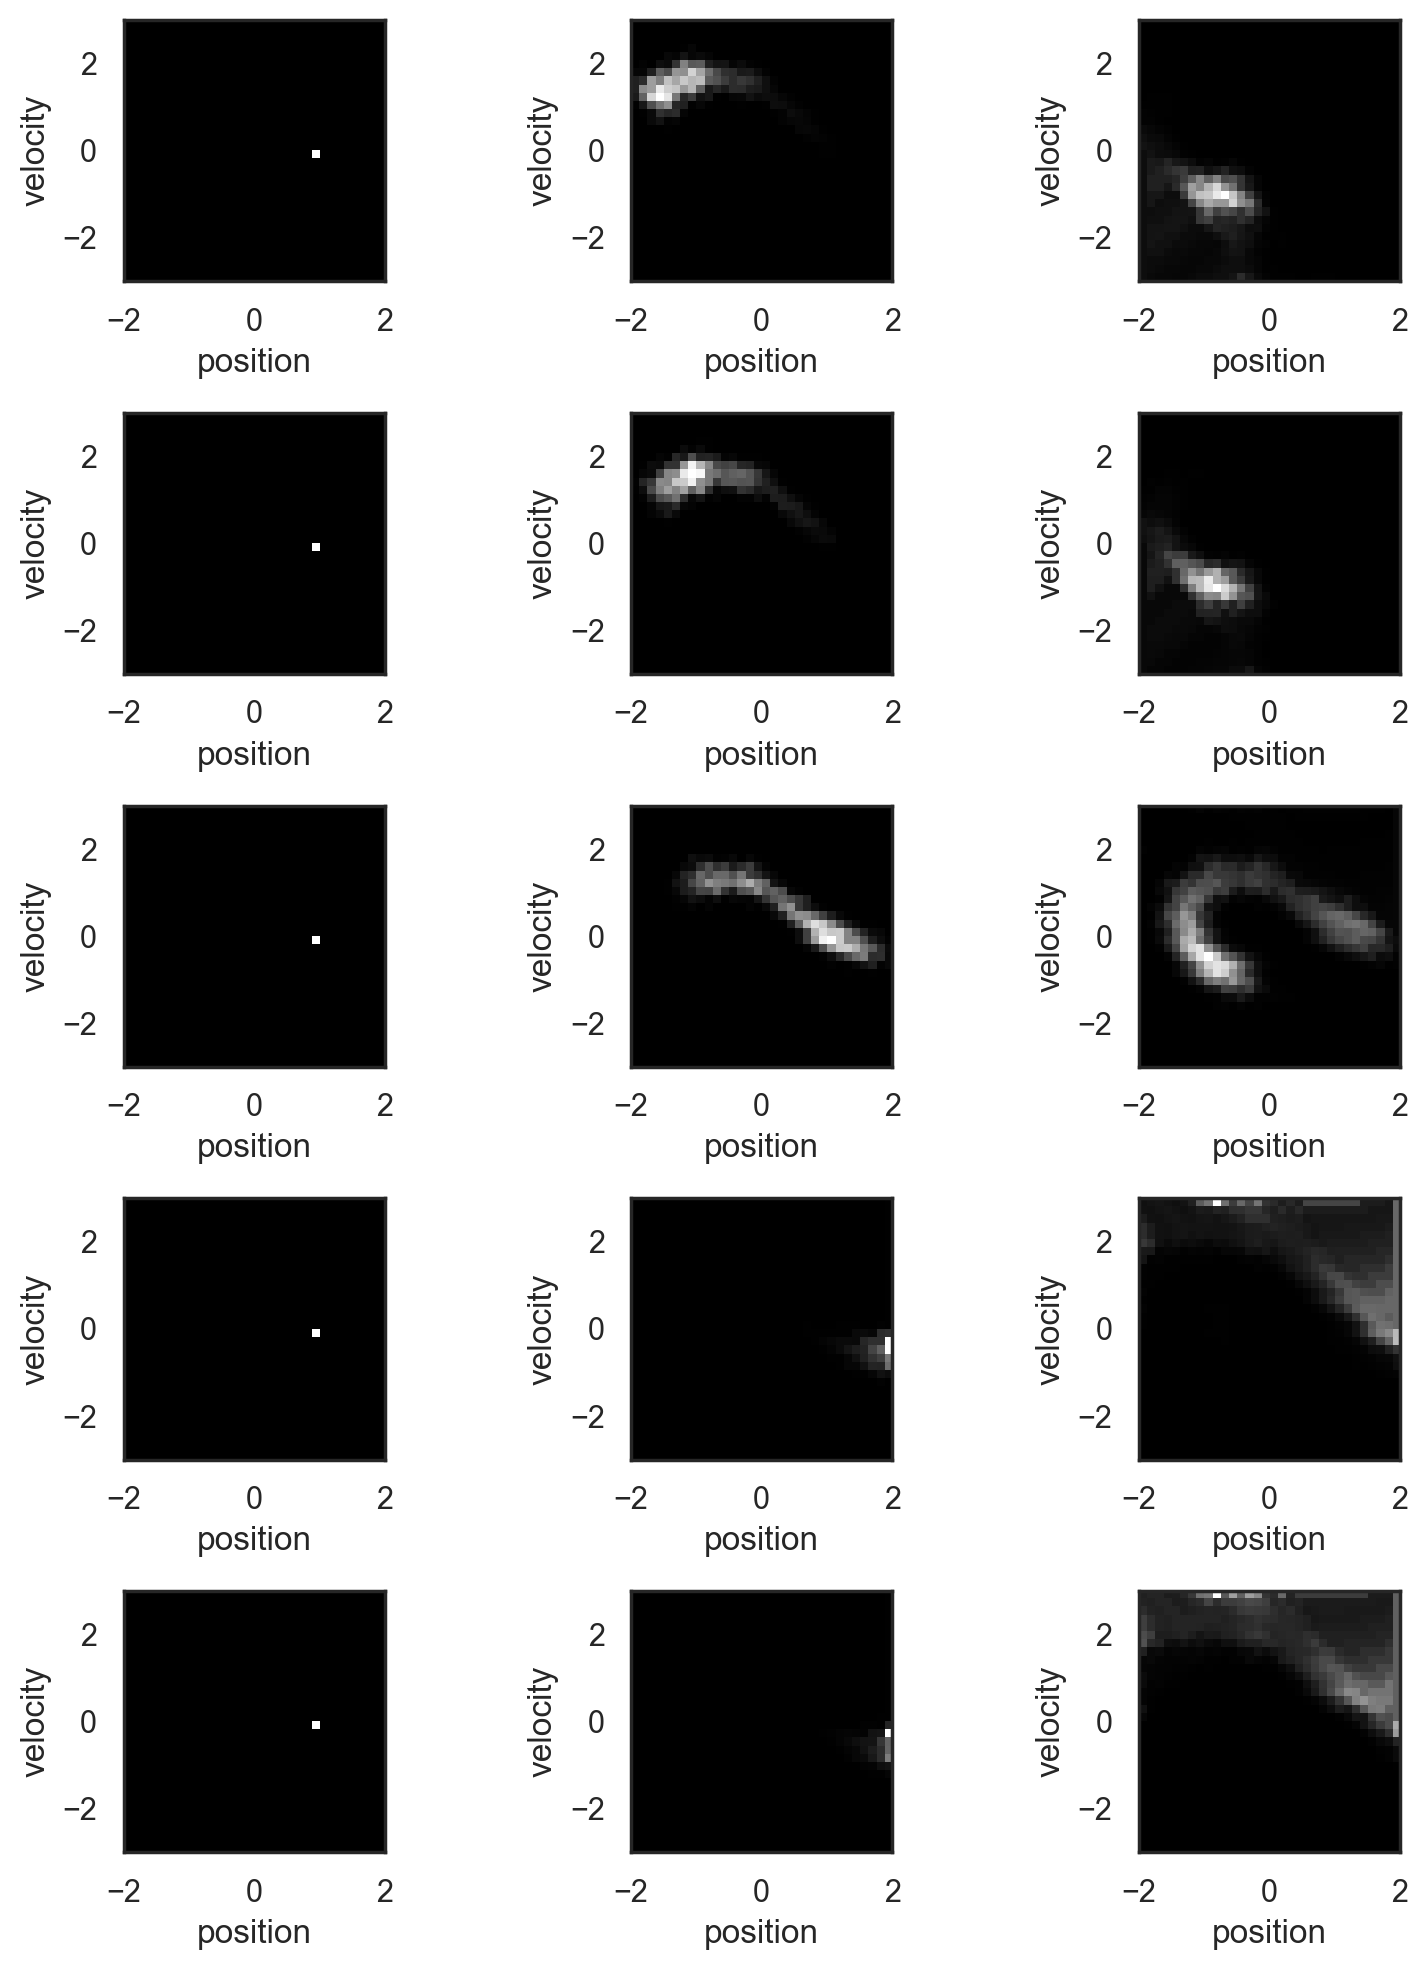

In [340]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(8, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

        try:
            ax = axes[idx_row, idx_col]
        except IndexError:
            ax = axes[idx_col]
        plot_belief(belief_plot[idx_row, idx_col], 
                    ax=ax, fig=fig, colorbar=False)

plt.tight_layout()

## Simulation

In [558]:
def log(x):
    return np.log(x + 1e-16)

class ActiveInferenceAgent:

    def __init__(self, b, n_action, n_step, goal_idx, starting_idx):
        
        self.goal_idx = goal_idx
        self.starting_idx = starting_idx
        
        self.n_state = b.shape[1]
        self.n_action = n_action
        
        self.n_step = n_step
        
        self.b = b                         # transition probabilities: action, state t, state t + 1
        self.a = np.eye(self.n_state)  # Mapping hidden state-observed state
        
        self.d = np.ones(self.n_action) / self.n_action
        
    def variational_energy_state(self, alpha, beta, t):
        
#         ve = np.zeros(self.n_state)
#         for i in range(self.n_state):
#             for j in range(self.n_action):
#                 for k in range(self.n_state):
#                     ve[i] += beta[t+1, j] * log(self.b[j, k, i]) * alpha[t+1, k]  # p(s_t|s_{t+1}, u_{t+1})
#                     ve[i] += beta[t, j] * log(self.b[j, i, k]) * alpha[t, k]    # p(s_{t-1}|s_{t} u_{t})
                    
#             if obs_t is not None:
#                 ve[i] += np.log(self.a.T[i] * obs_t)
        ve = np.zeros(self.n_state)
        # for i in range(self.n_state):
        for i in range(self.n_action):
            # for k in range(self.n_state):
            ve += beta[t+1, i] * np.log(np.dot(self.b[i], alpha[t+1])+1e-16) 
            # ve += beta[t+1, i] * np.log(np.dot(self.b[i], alpha[t+1])+1e-16)  # p(s_t|s_{t+1}, u_{t+1})
            # ve += beta[t, i] * np.log(np.dot(self.b[i].T, alpha[t])+1e-16)  # p(s_{t-1}|s_{t} u_{t})

        return ve
    
    def variational_energy_action(self, t, alpha):
        
#         ve = np.zeros(self.n_action)
#         for k in range(self.n_action):
#             for i in range(self.n_state):
#                 for j in range(self.n_state):
#                     ve[k] += alpha[t-1, i] * log(self.b[k, j, i]) * alpha[t, j] 
#             ve[k] += log(self.d[k])

        ve = np.zeros(self.n_action)
        for i in range(self.n_action):
            # ve[i] += np.dot(alpha[t-1].T, np.log(np.dot(self.b[i], alpha[t]+1e-16)))
            ve[i] += np.dot(alpha[t-1].T, np.dot(np.log(self.b[i]+1e-16), alpha[t]))
            ve[i] += np.log(self.d[i]+1e-16)
        return ve
    
    def update_sufficient_statistics(
                self, 
                k,  # Current 'real' time
                n_epoch,
                alpha,
                beta
            ):
            
        new_alpha = np.copy(alpha)
        new_beta = np.copy(beta)

        for epoch in tqdm(range(n_epoch), position=1, leave=False, desc="Epoch"):
            for t in reversed(range(k+1, self.n_step-1)):

                new_alpha[t] = np.exp(self.variational_energy_state(
                    t=t,
                    alpha=alpha,
                    beta=beta))

                new_beta[t] = np.exp(self.variational_energy_action(
                        alpha=alpha,
                        t=t))

                sum_alpha_t = np.sum(new_alpha[t])
                if sum_alpha_t > 0:
                    alpha[t] = new_alpha[t] / sum_alpha_t
                sum_beta_t = np.sum(new_beta[t])
                if sum_beta_t > 0:
                    beta[t] = new_beta[t] / sum_beta_t

        return alpha, beta

In [559]:
n_step = 16
n_epoch = 10

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)

tree = scipy.spatial.KDTree(coords)

goal = np.array([1.0, 0.0]) # goal = np.array([1.0, -1.0]) # goal = np.array([1.0, 0.0])
_, goal_idx = tree.query(goal)

starting = np.array([0.0, 0.0])
_, starting_idx = tree.query(starting)

agent = ActiveInferenceAgent(b=p_backward, n_step=n_step, n_action=n_action, 
                             goal_idx=goal_idx, starting_idx=starting_idx)

hist_alpha = np.zeros((n_step, n_step, n_state))
hist_beta = np.zeros((n_step, n_step, n_action))

actions = np.ones(n_step, dtype=int) * -1
observations = np.ones(n_step, dtype=int) * -1
trajectory = np.ones((n_step, 2)) * -1

for k in tqdm(range(n_step), position=0, desc="Step"):
    if k == 0:
        alpha = np.ones((n_step, n_state)) / n_state  # State dist sufficient statistics
        beta = np.ones((n_step, n_action)) / n_action # Action dist sufficient statistics

        alpha[-1, :] = 0.
        alpha[-1, goal_idx] = 1.    # Encode the goal
            
        action_idx = -1
        state_idx = starting_idx

    else:
        action_idx = np.argmax(beta[k])
        state_idx = np.random.choice(np.arange(n_state), p=p[action_idx, state_idx, :]) 
        
    alpha[k, :] = 0.
    alpha[k, state_idx] = 1. # Encode the knowledge of current state
    
#     if k != 0:
#         beta[k, :] = 0.
#         beta[k, action_idx] = 1. # Encode the knowledge of current state

    observations[k] = state_idx
    actions[k] = action_idx
    trajectory[k] = coords[state_idx] 
    
    alpha, beta = agent.update_sufficient_statistics(
        k=k, 
        n_epoch=n_epoch, 
        alpha=alpha,
        beta=beta) 
    
    hist_alpha[k] = alpha
    hist_beta[k] = beta

Step:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [560]:
hist_alpha[0, 0]

array([0., 0., 0., ..., 0., 0., 0.])

(-3.0, 3.0)

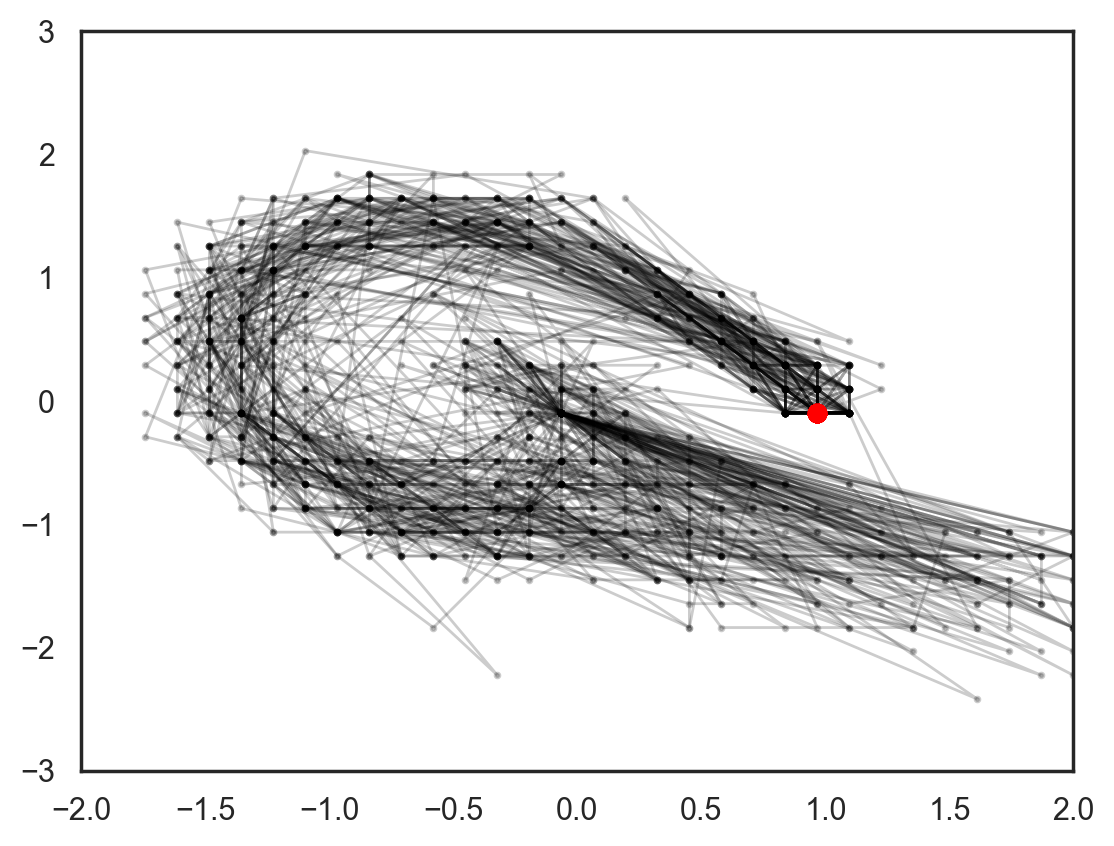

In [561]:
n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))
alpha = hist_alpha[0]
beta = hist_beta[0]

for i in range(n_sample):
    for t in range(0, n_step):
        state_idx = np.random.choice(np.arange(n_state), p=alpha[t])
        sample_trajectories[i, t] = coords[state_idx]
    

fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3)    

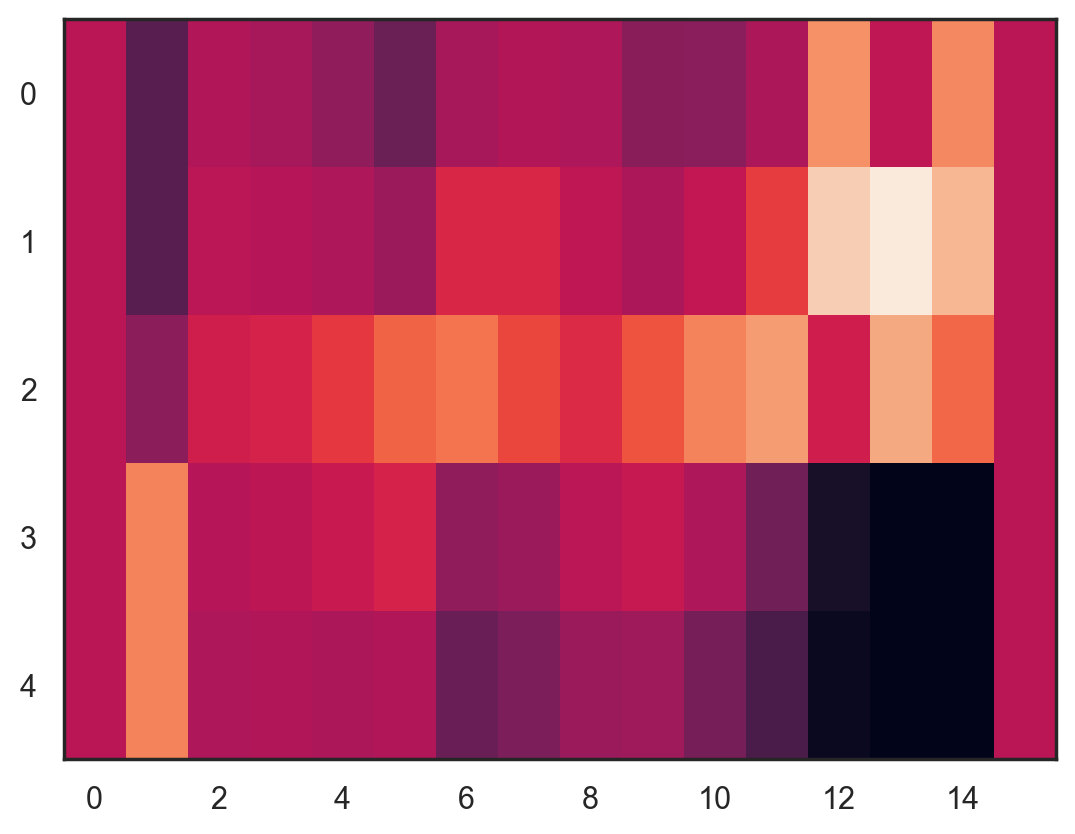

In [562]:
plt.imshow(hist_beta[0].T, aspect="auto", interpolation='none');

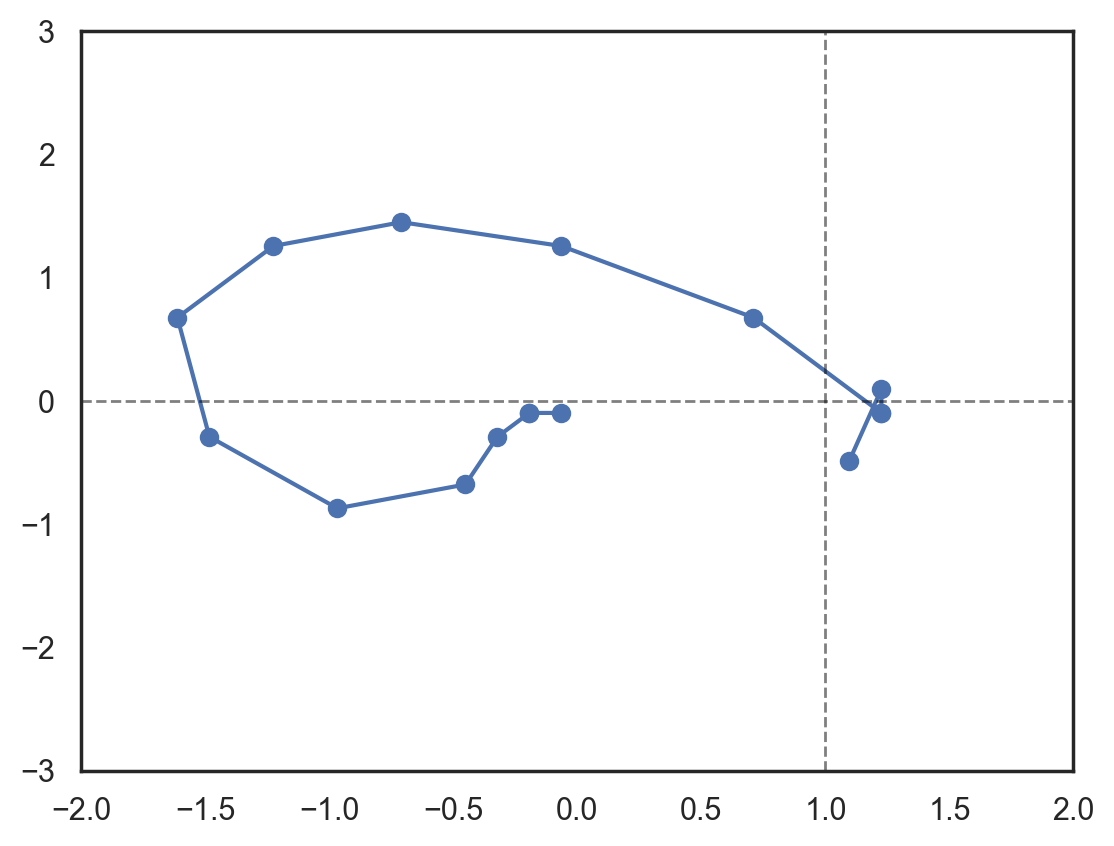

In [563]:
fig, ax = plt.subplots()

ax.scatter(x=trajectory[:, 0], y=trajectory[:, 1])
ax.plot(trajectory[:, 0], trajectory[:, 1])
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3)
ax.axhline(y=0.0, ls="--", lw=1, color="black", alpha=0.5)
ax.axvline(x=1.0, ls="--", lw=1, color="black", alpha=0.5)

In [529]:
trajectory[-4:, ]

array([[ 0.83870968,  0.48387097],
       [ 1.09677419,  0.29032258],
       [ 1.22580645,  0.09677419],
       [ 1.35483871, -0.29032258]])

### Debug

In [107]:
starting = np.array([0.0, 0.0])
_, state_idx = tree.query(starting)
state_idx

495

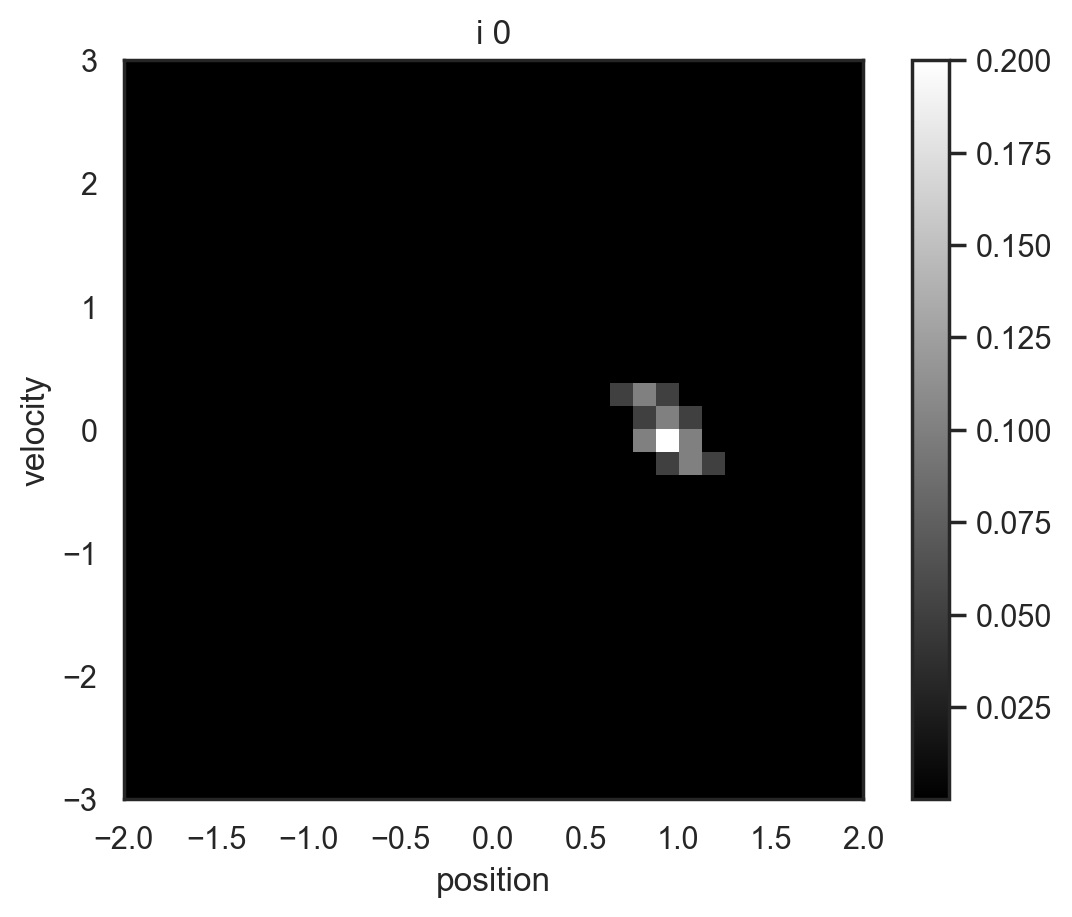

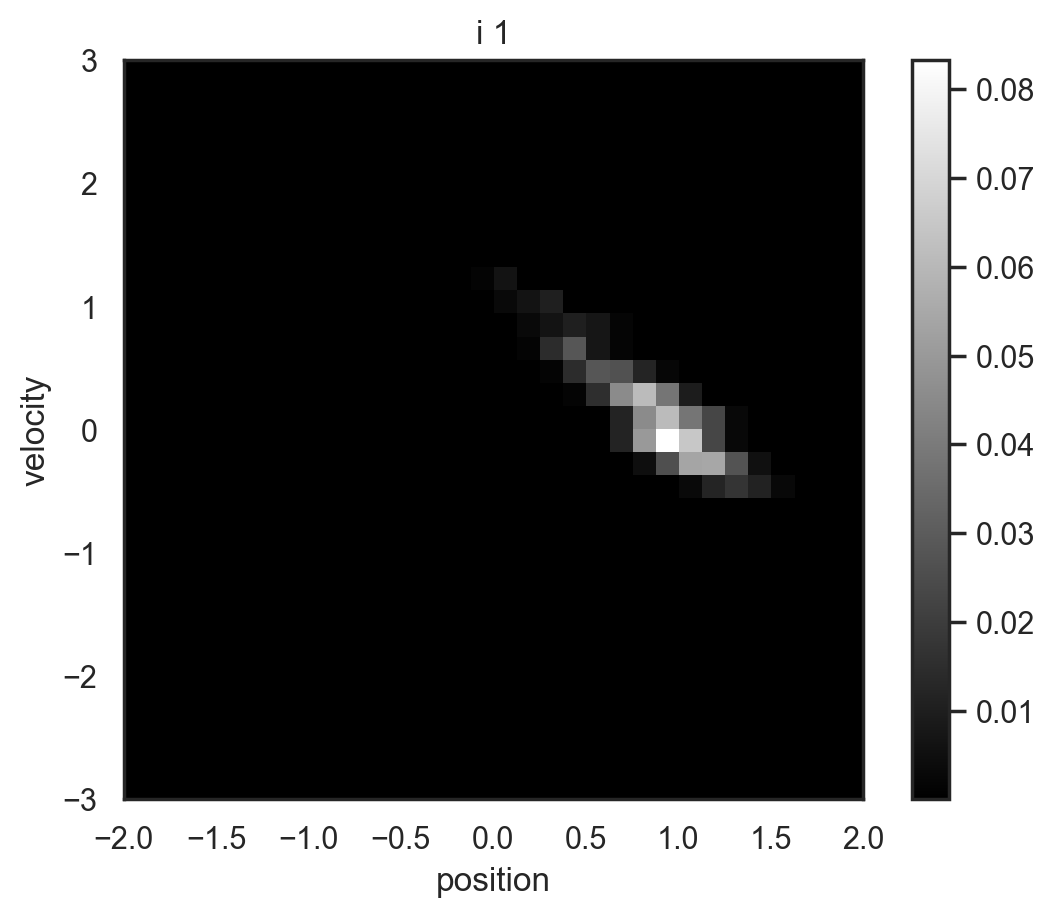

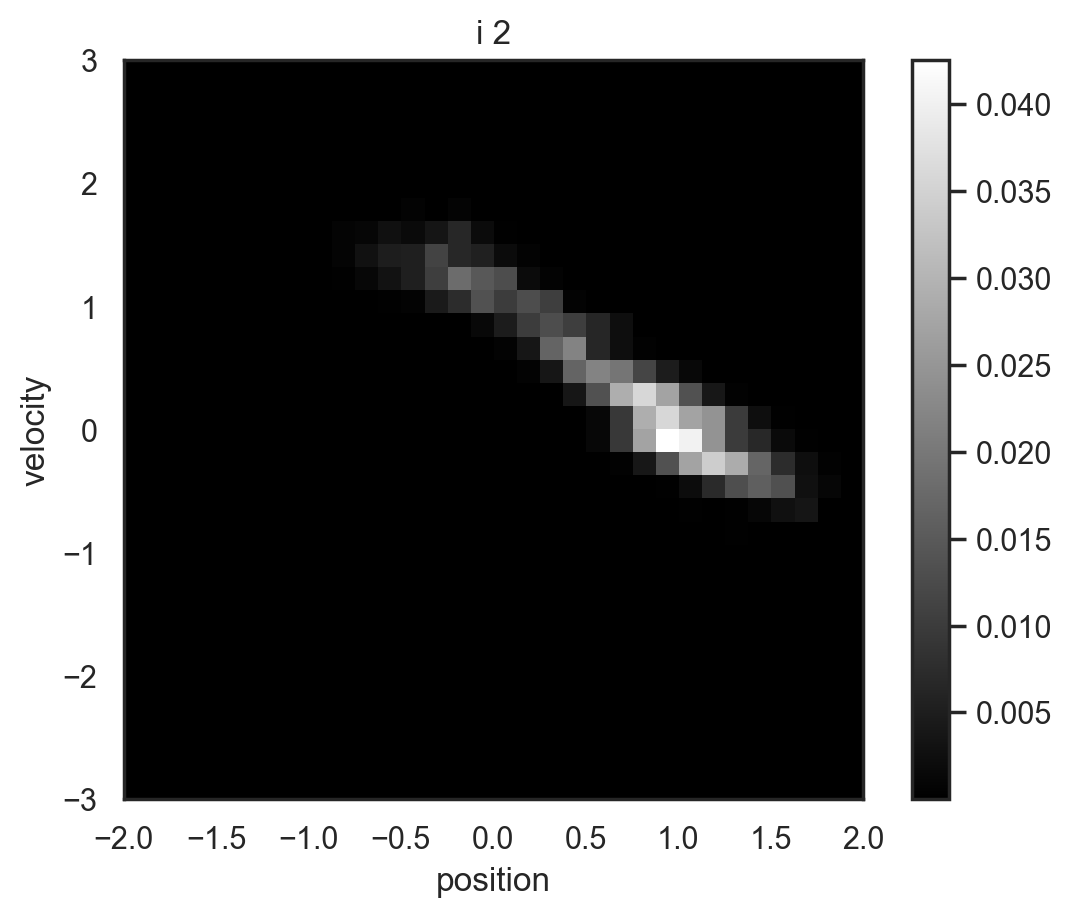

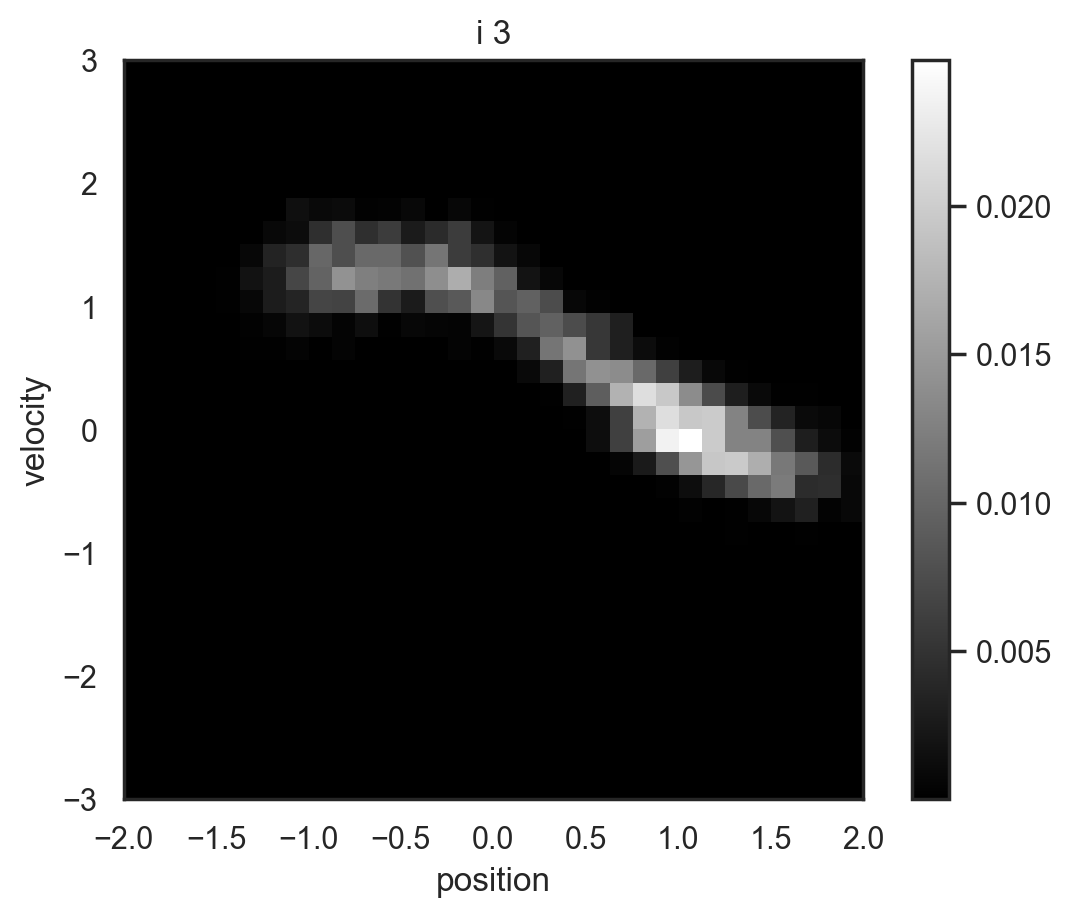

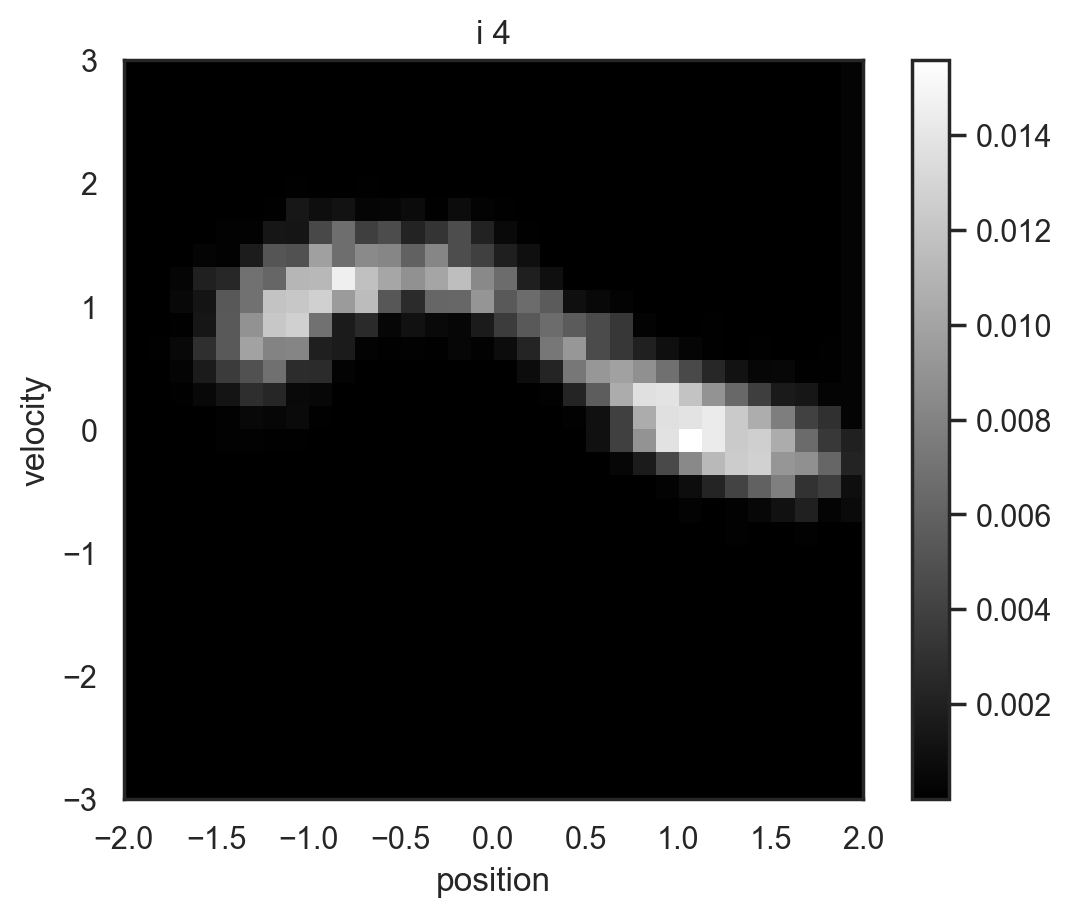

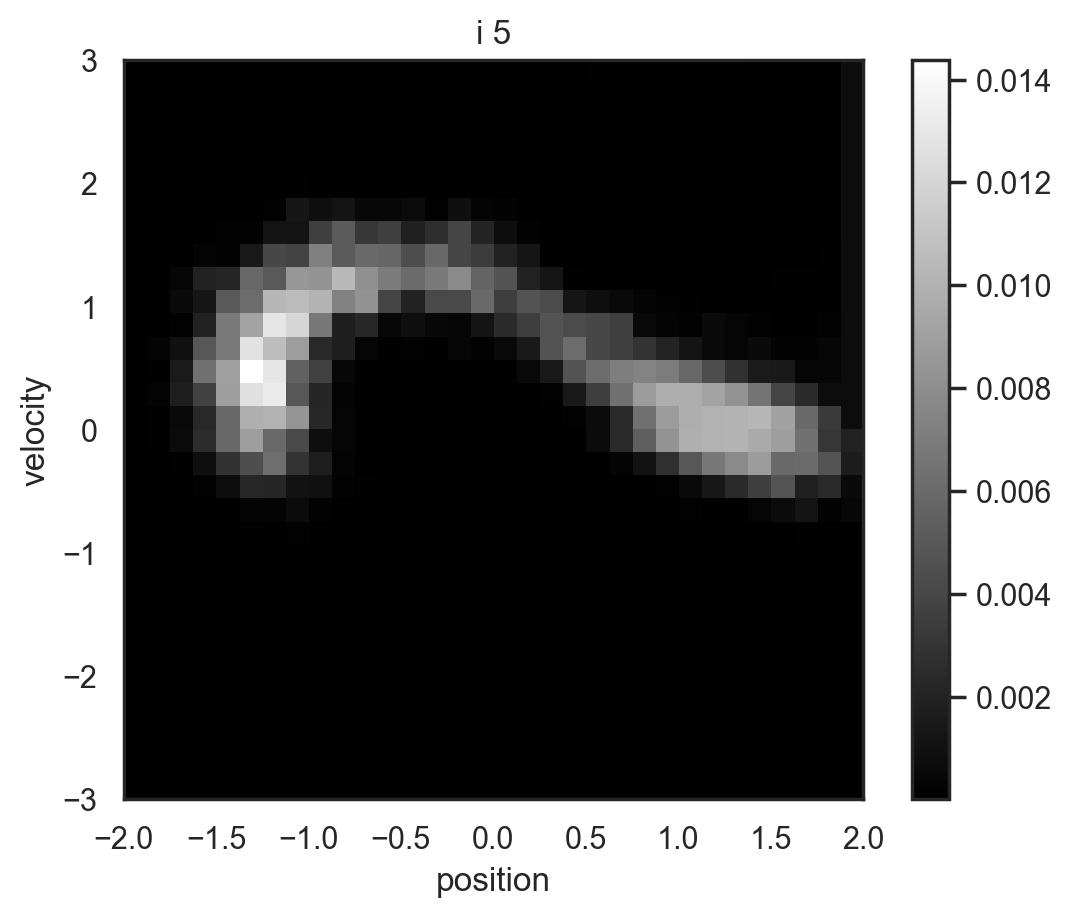

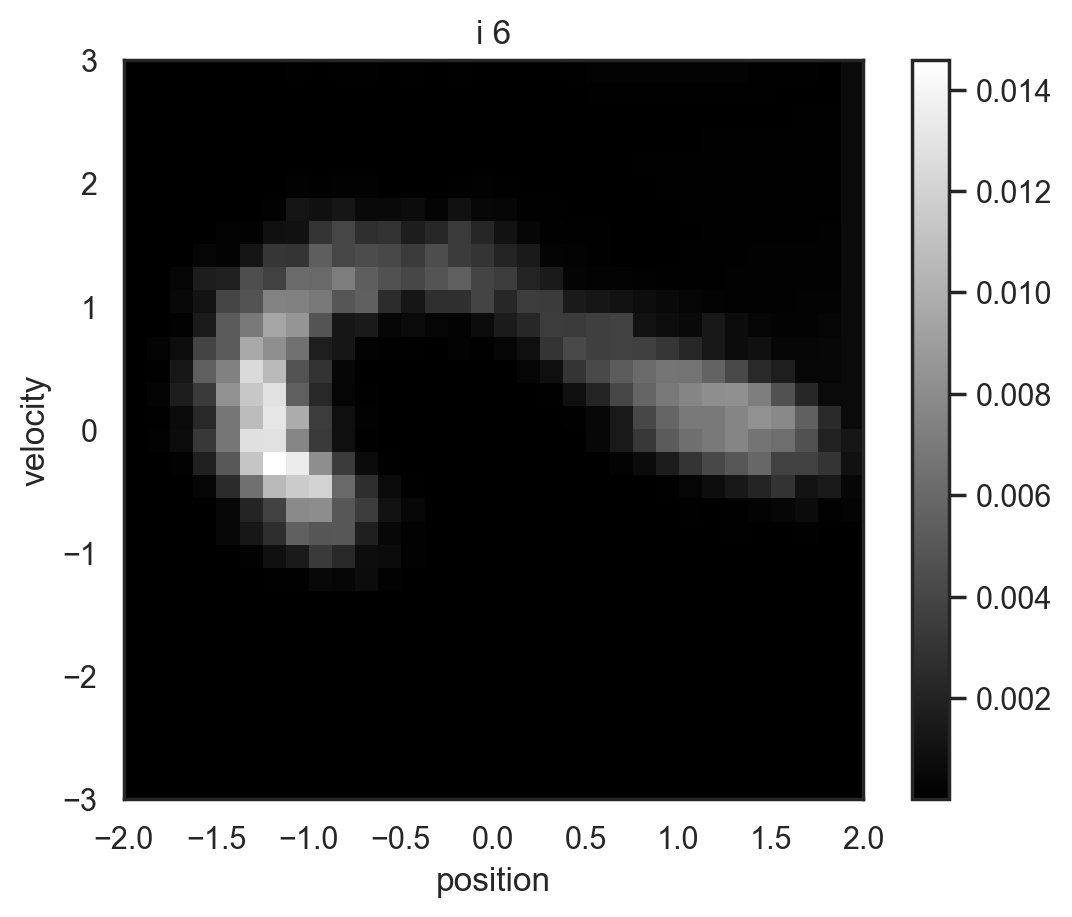

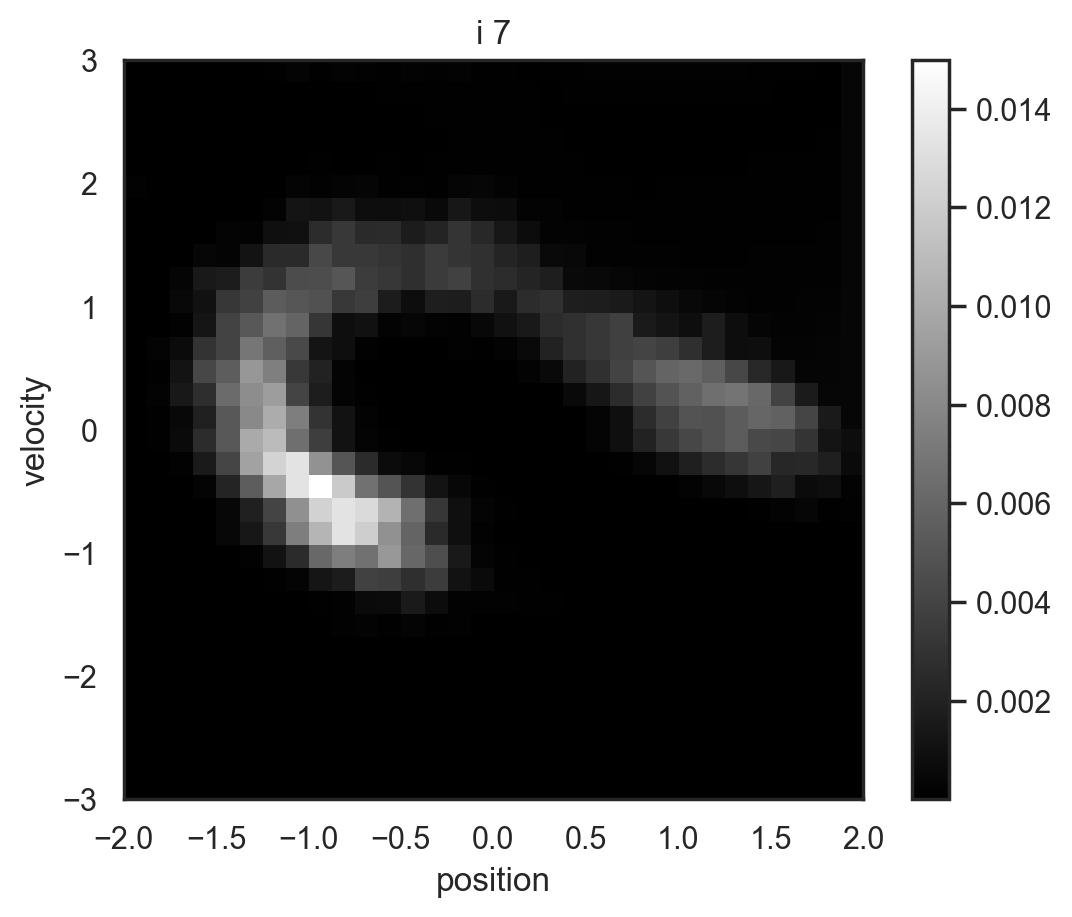

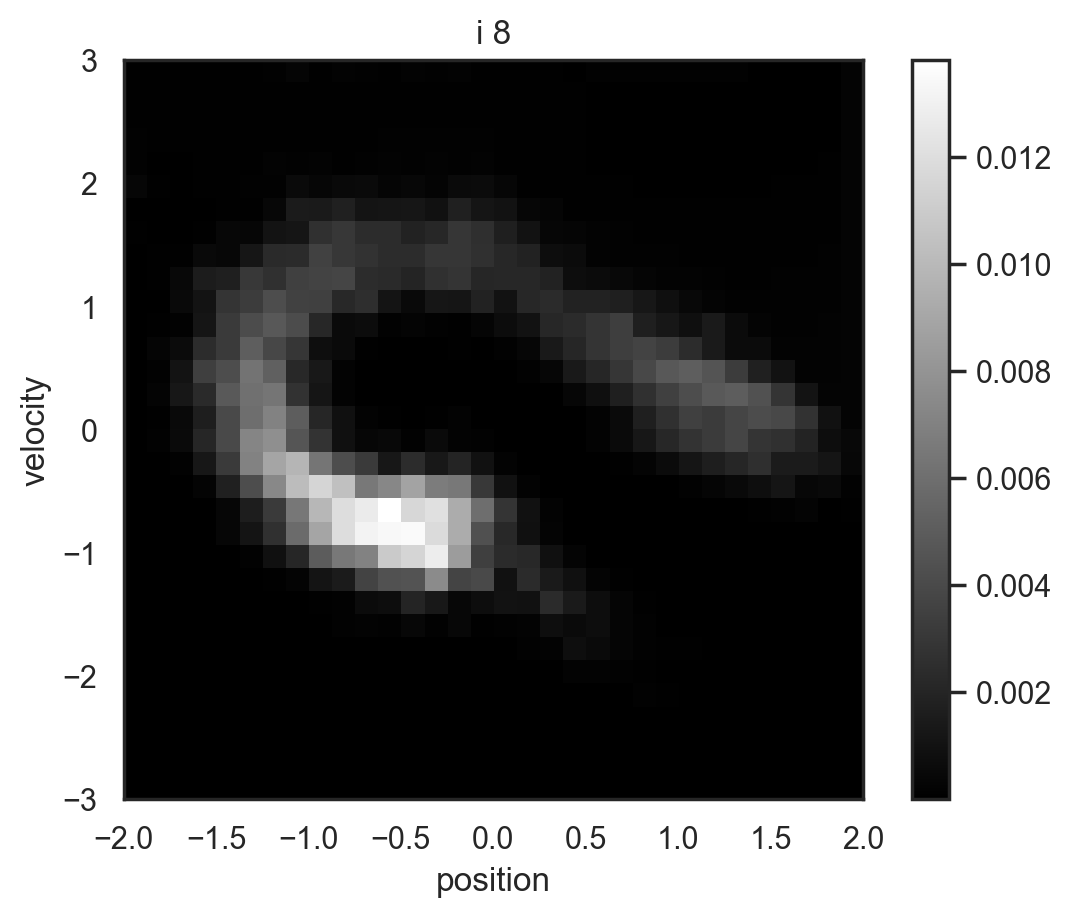

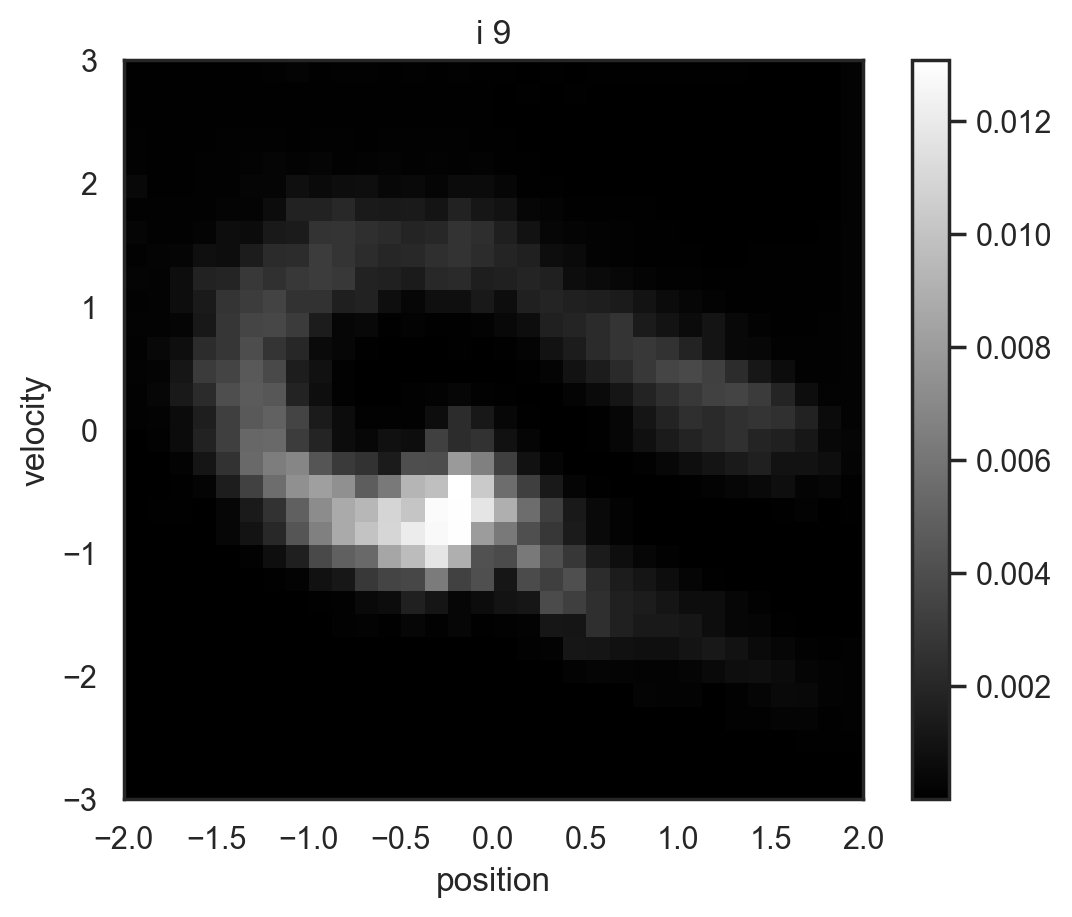

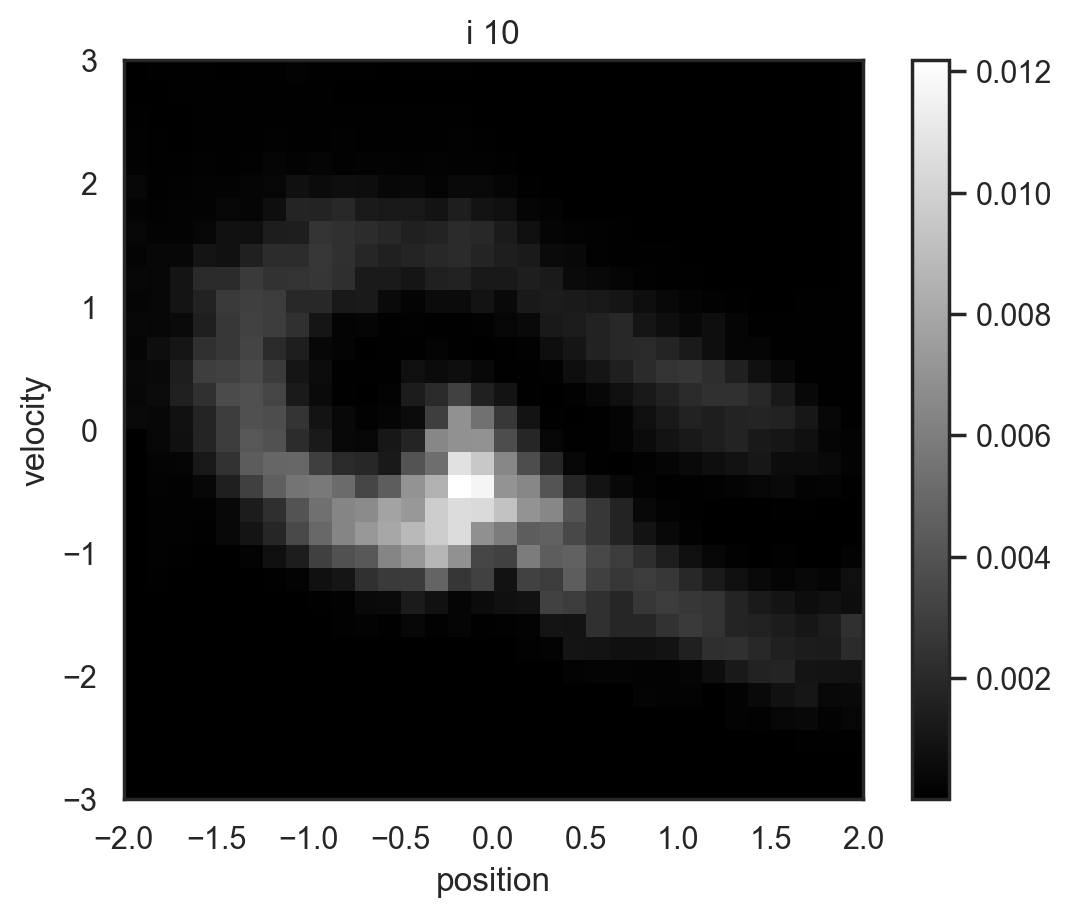

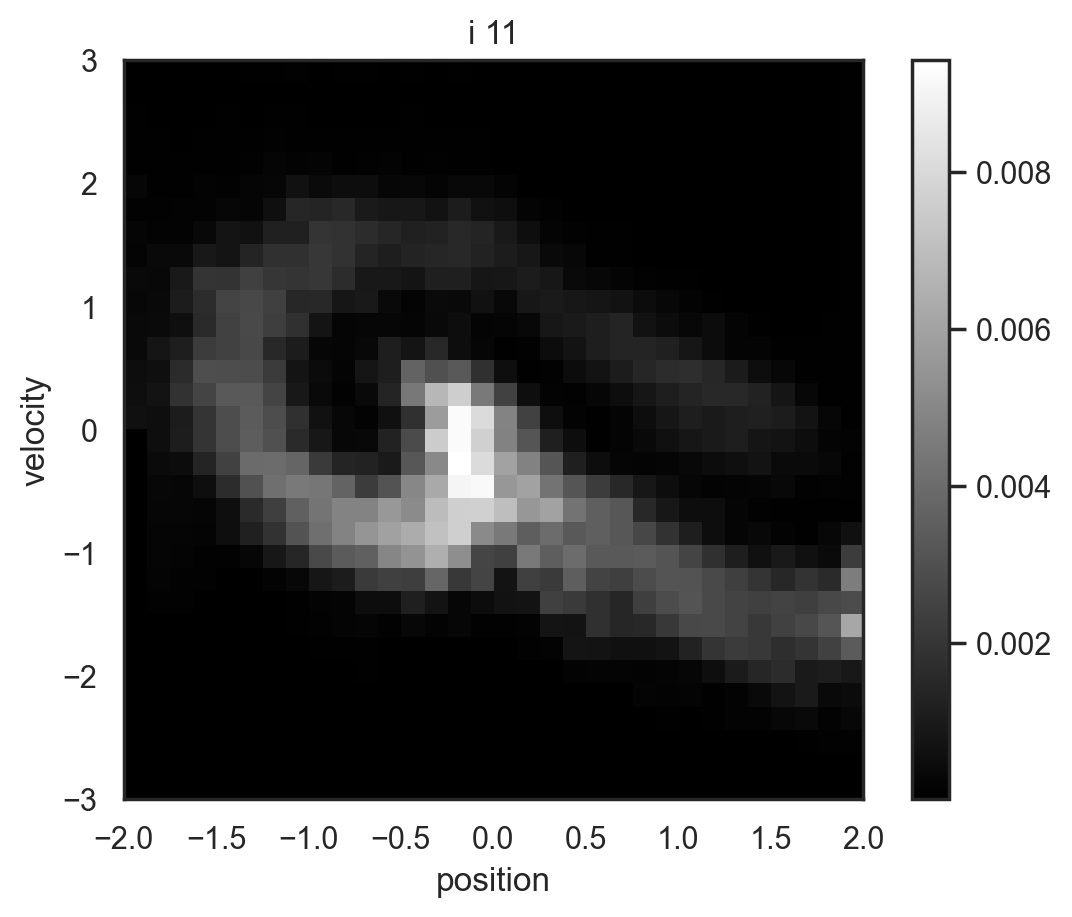

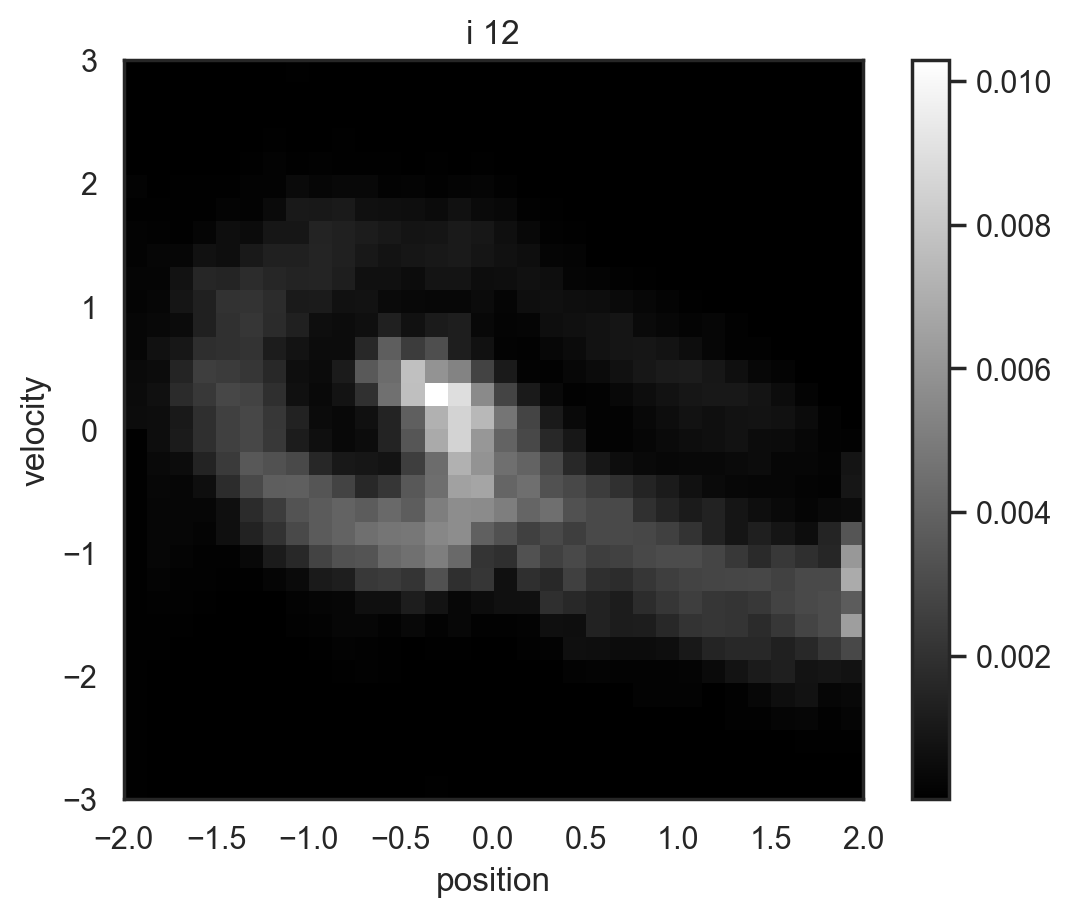

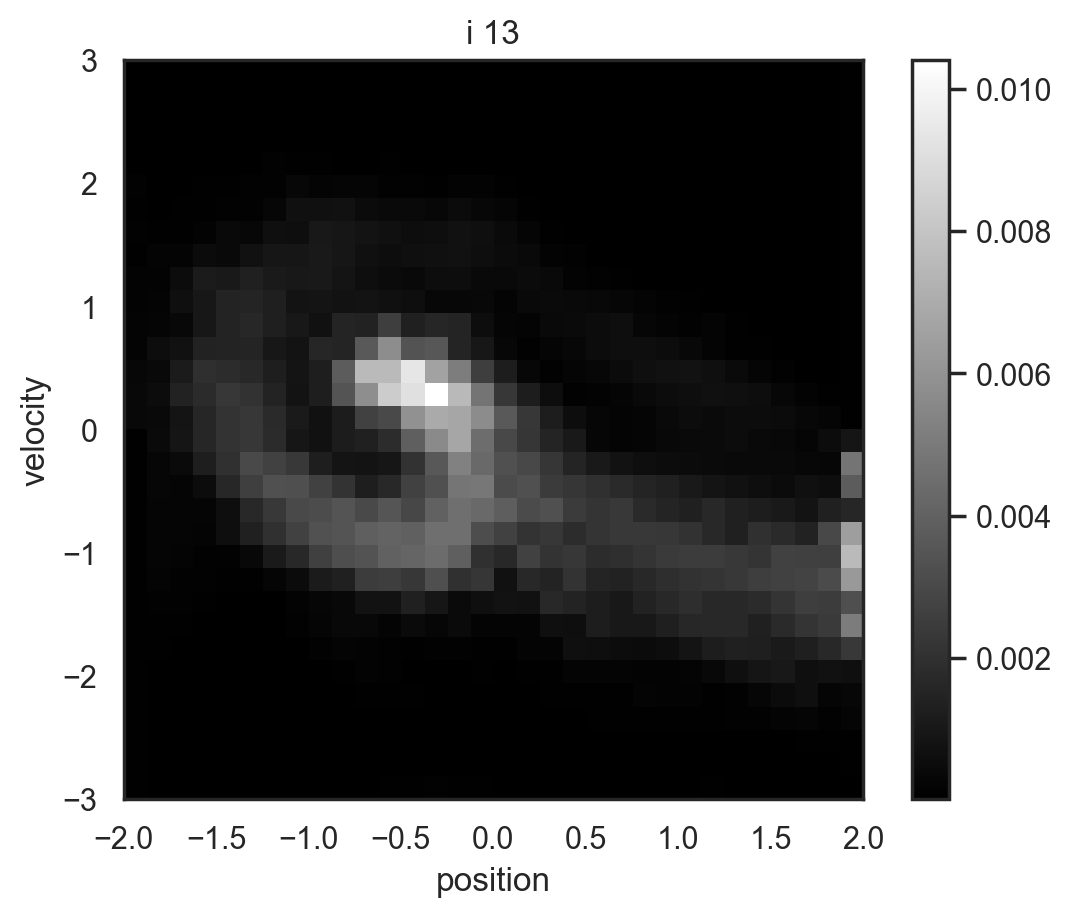

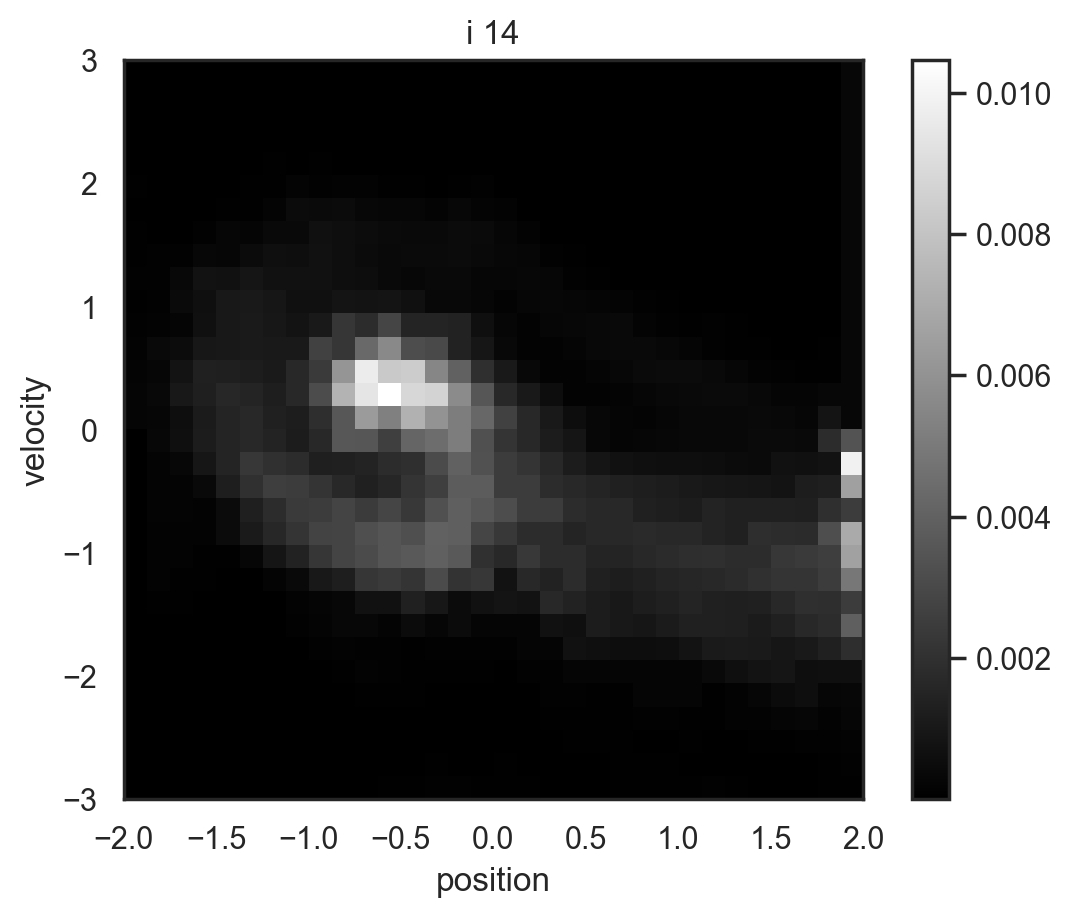

In [357]:
alpha = np.ones((n_step, n_state)) / n_state  # State dist sufficient statistics
beta = np.ones((n_step, n_action)) / n_action # Action dist sufficient statistics

alpha[-1] = 0.
alpha[-1, goal_idx] = 1. # Encode the goal

beta[:] = 0.
beta[:, 2] = 1. # Encode the action you want

b = p_backward

idx_act = 2

t = n_step - 2
i = 0
for t in reversed(range(n_step-1)):
#     ve = np.zeros(n_state)
#     for j in range(n_action):
#         ve_j = beta[t+1, j] * np.dot(log(b[j].T), alpha[t+1])
#         ve += ve_j
#     alpha[t] = np.exp(ve)
    alpha[t] = np.exp(np.log(np.dot(p_backward[idx_act]+1e-8, alpha[t+1])))
    
# fig, ax = plt.subplots()
# im = ax.imshow(np.exp(ve).reshape((32, -1)), vmin=0, vmax=1, interpolation='none')
# fig.colorbar(im);
    plot_belief(alpha[t])
    plt.title(f"i {i}")
    i += 1

In [95]:
# n_state = 3
# a = np.random.random(n_state)
# b = np.random.random((n_state, n_state))

In [ ]:
# new_b = np.zeros_like(b)
# for idx_future in range(state_space_size):
#     for idx_past in range(state_space_size):
#         new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_past, idx_future]

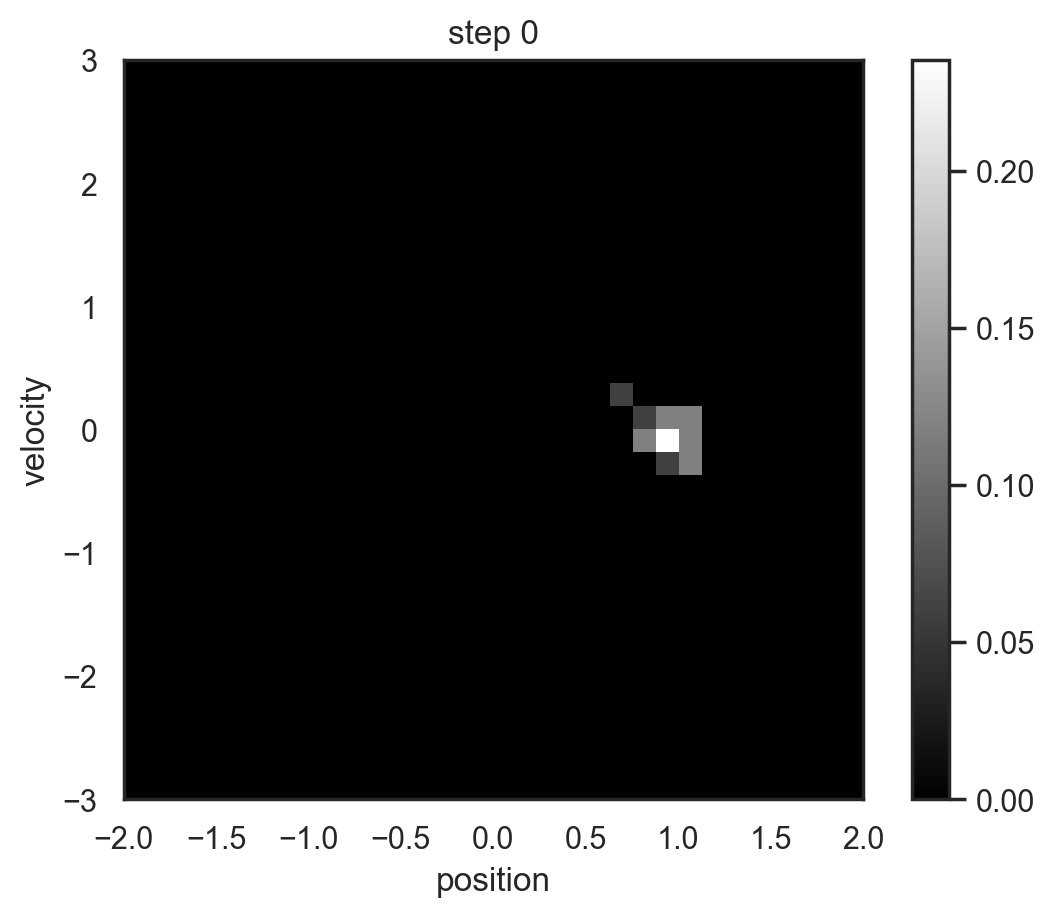

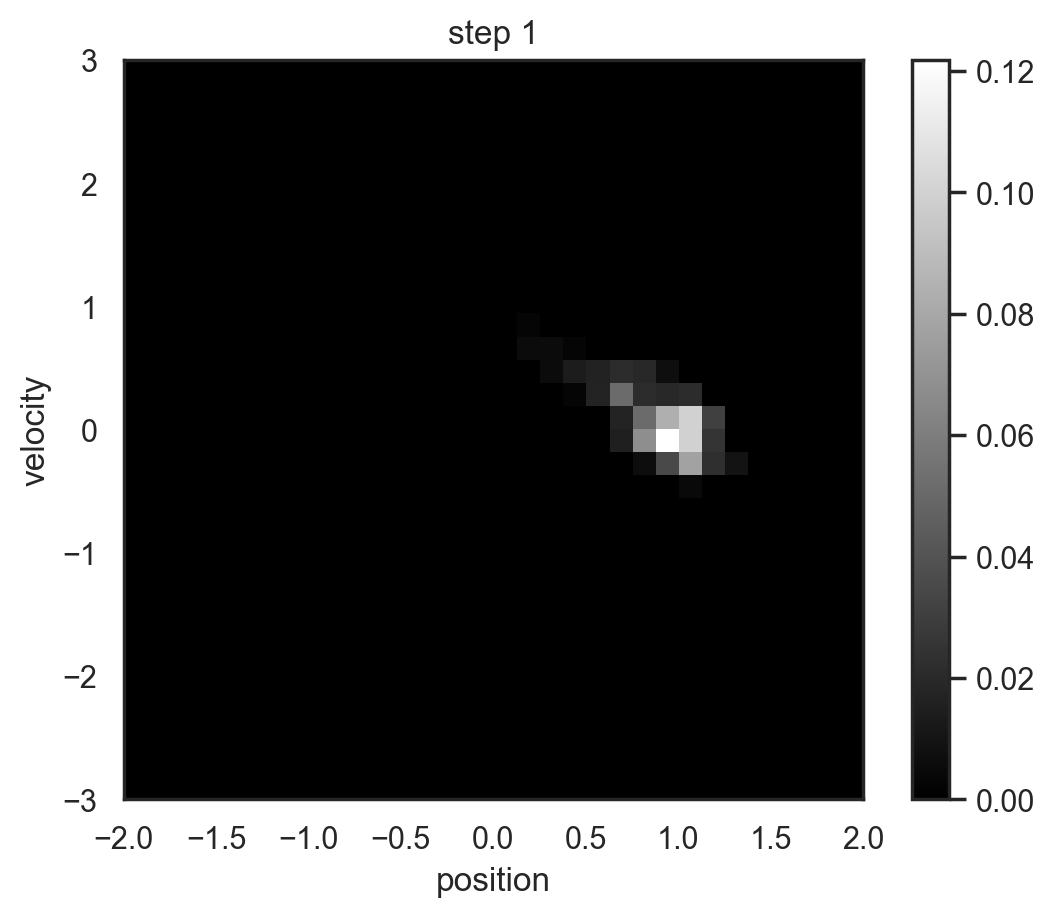

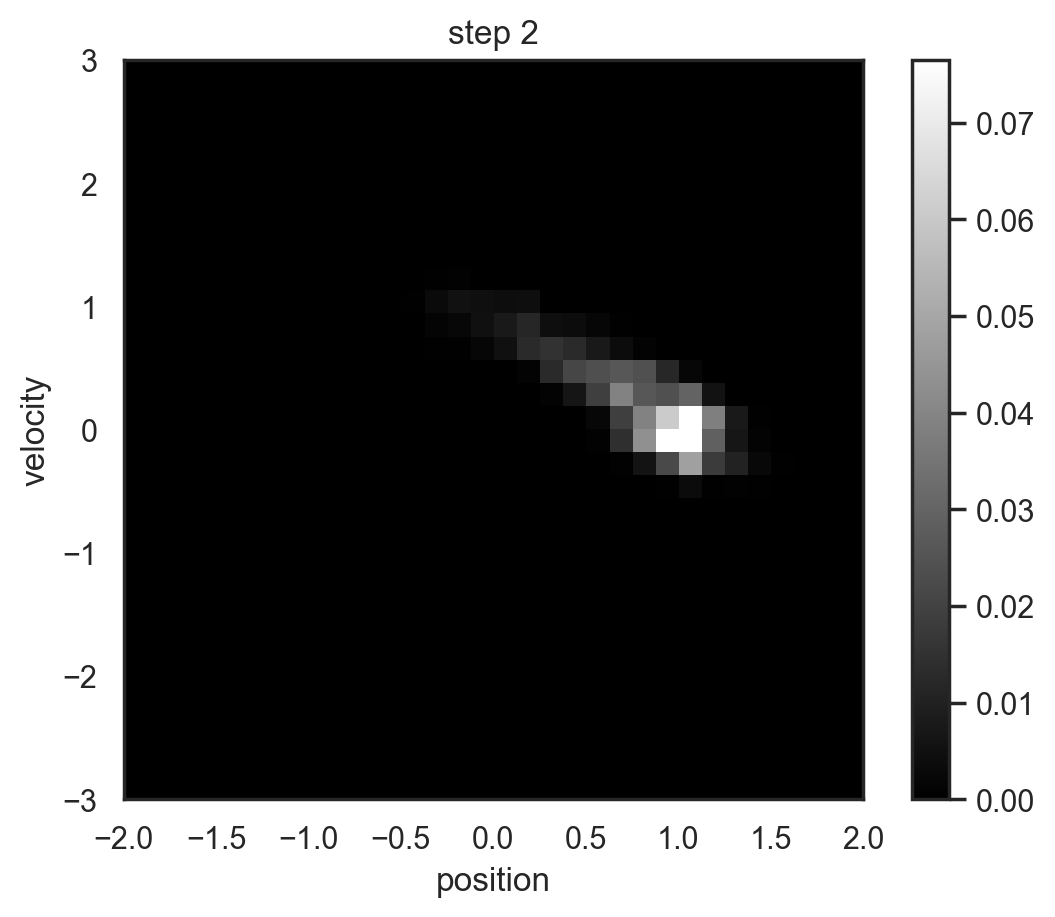

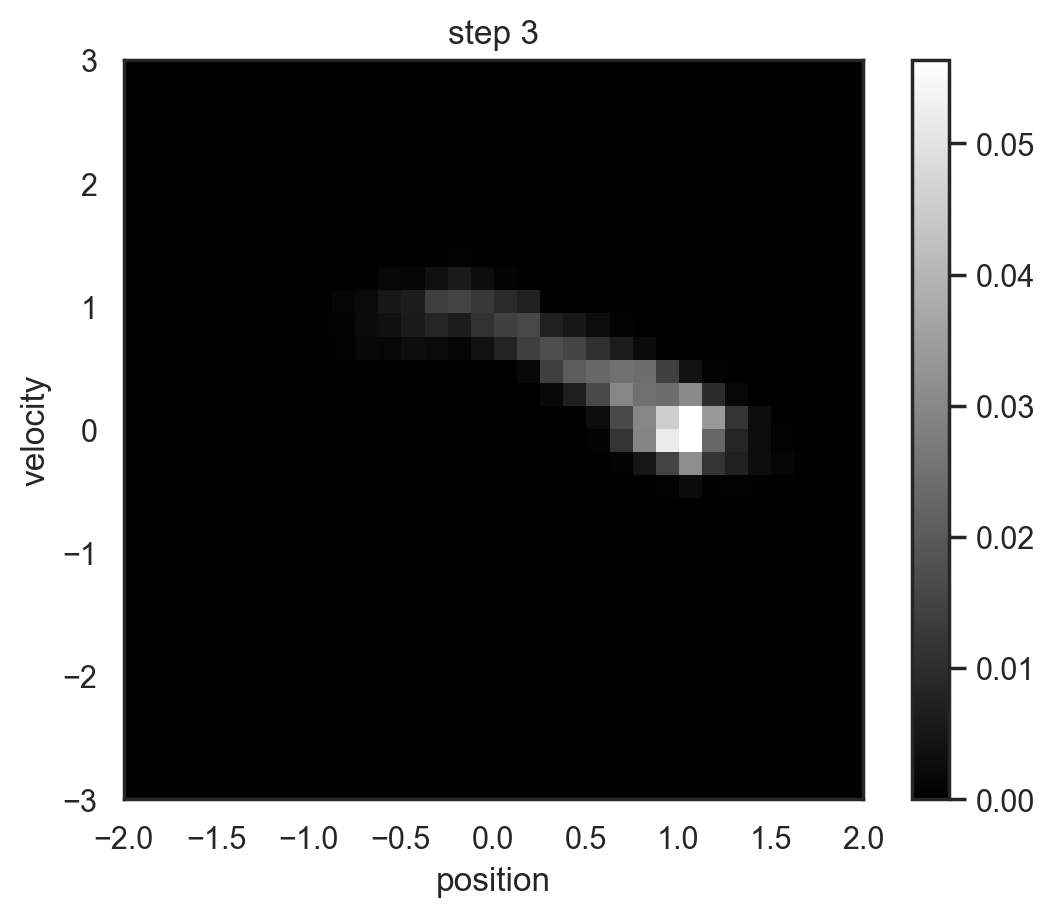

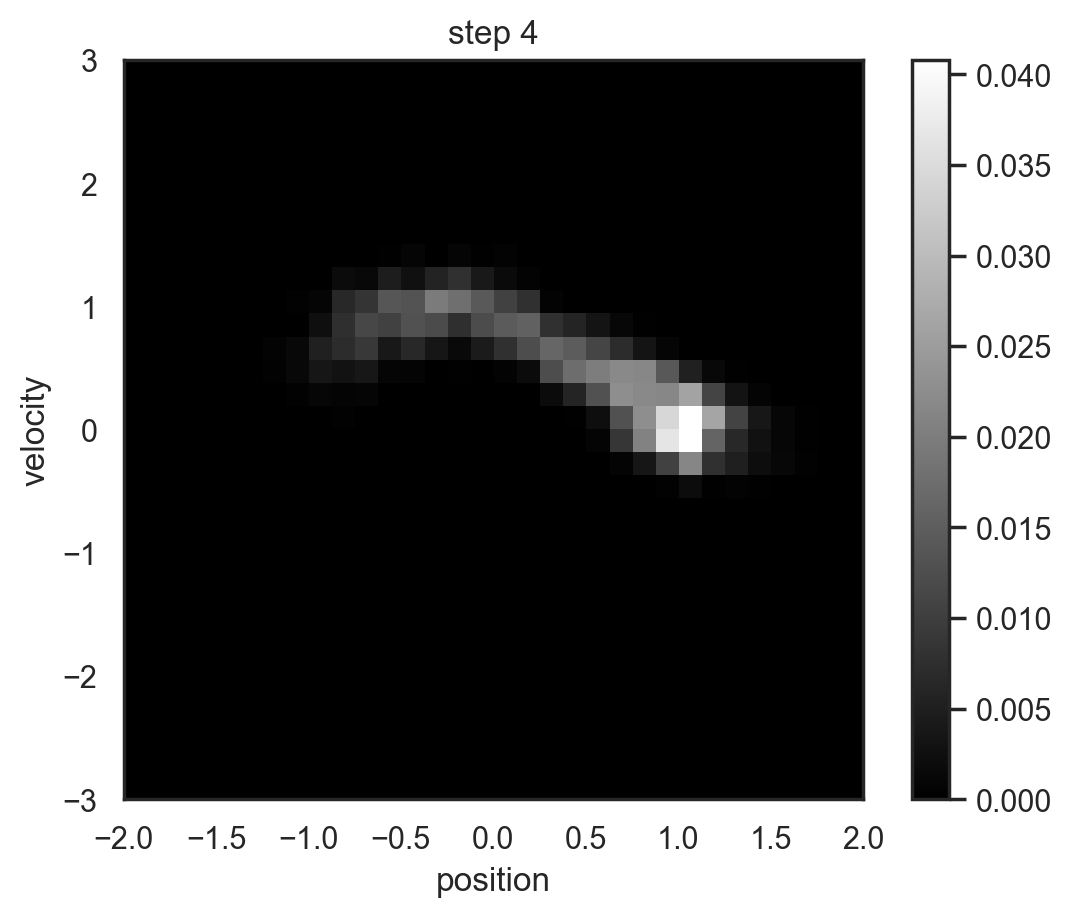

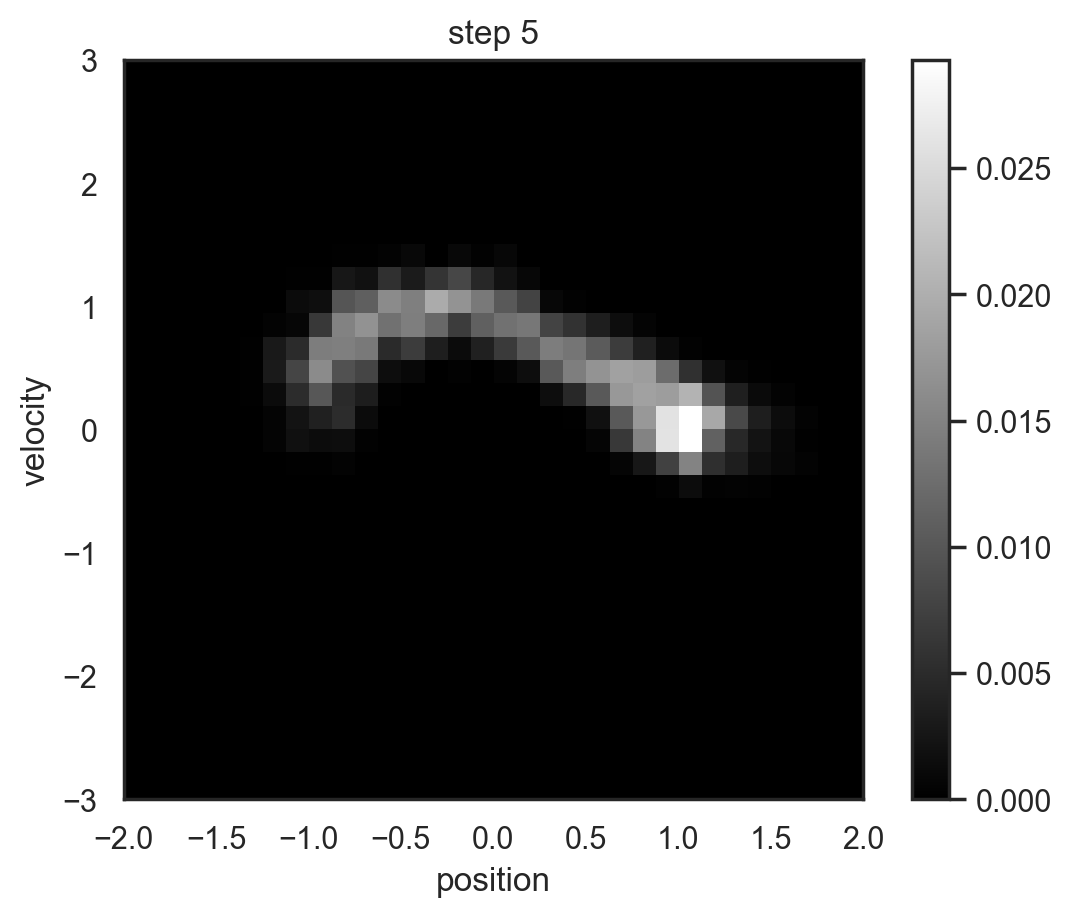

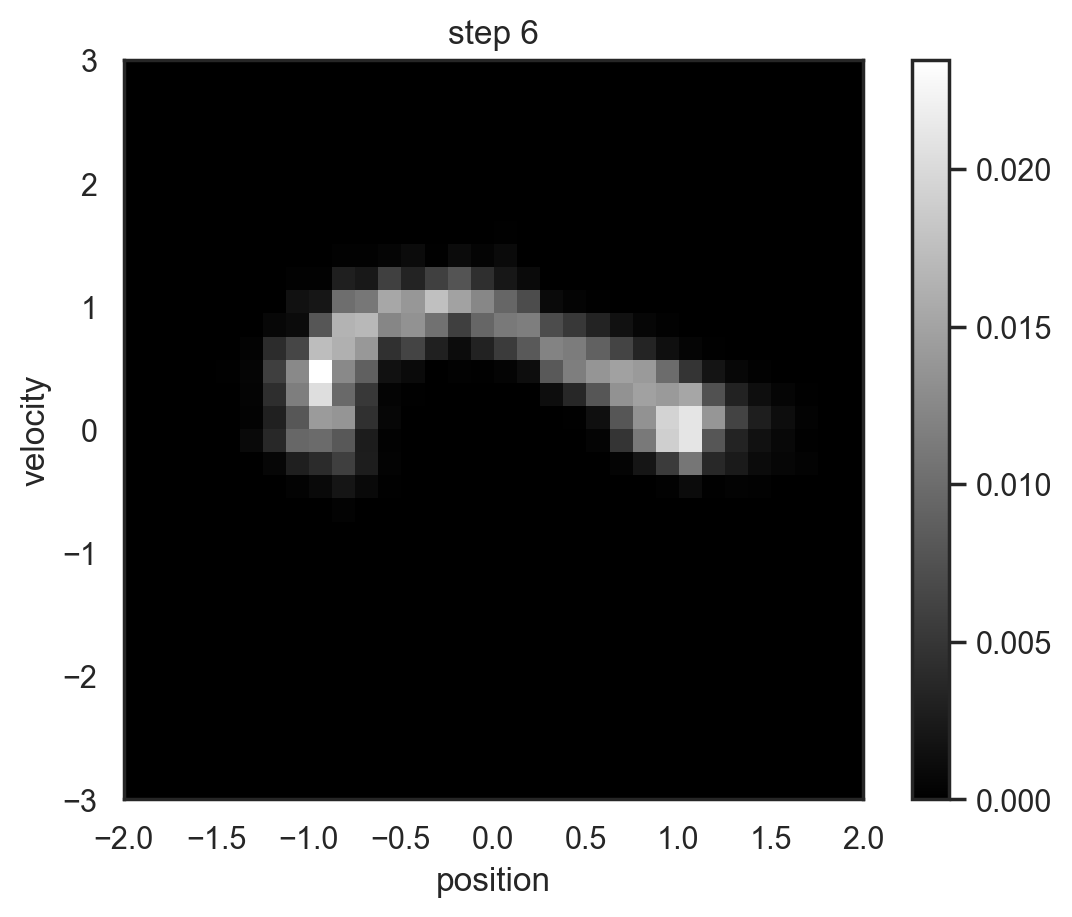

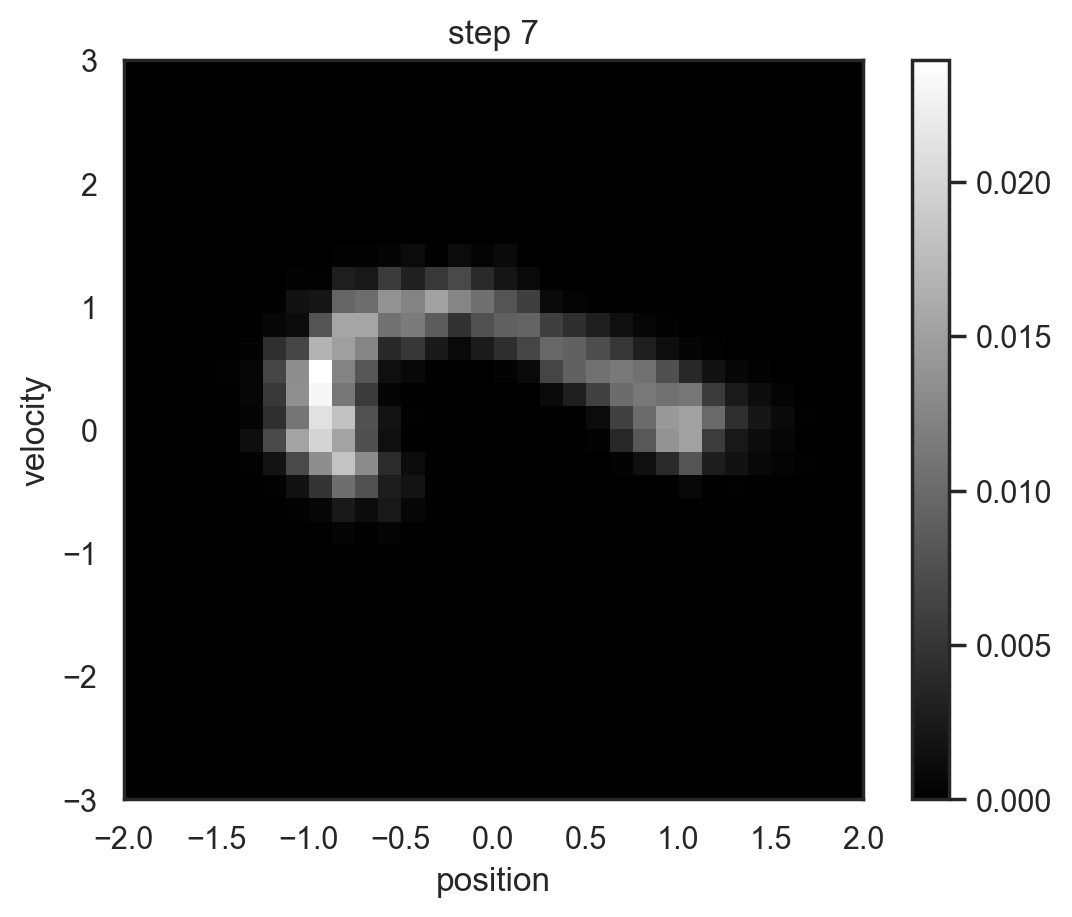

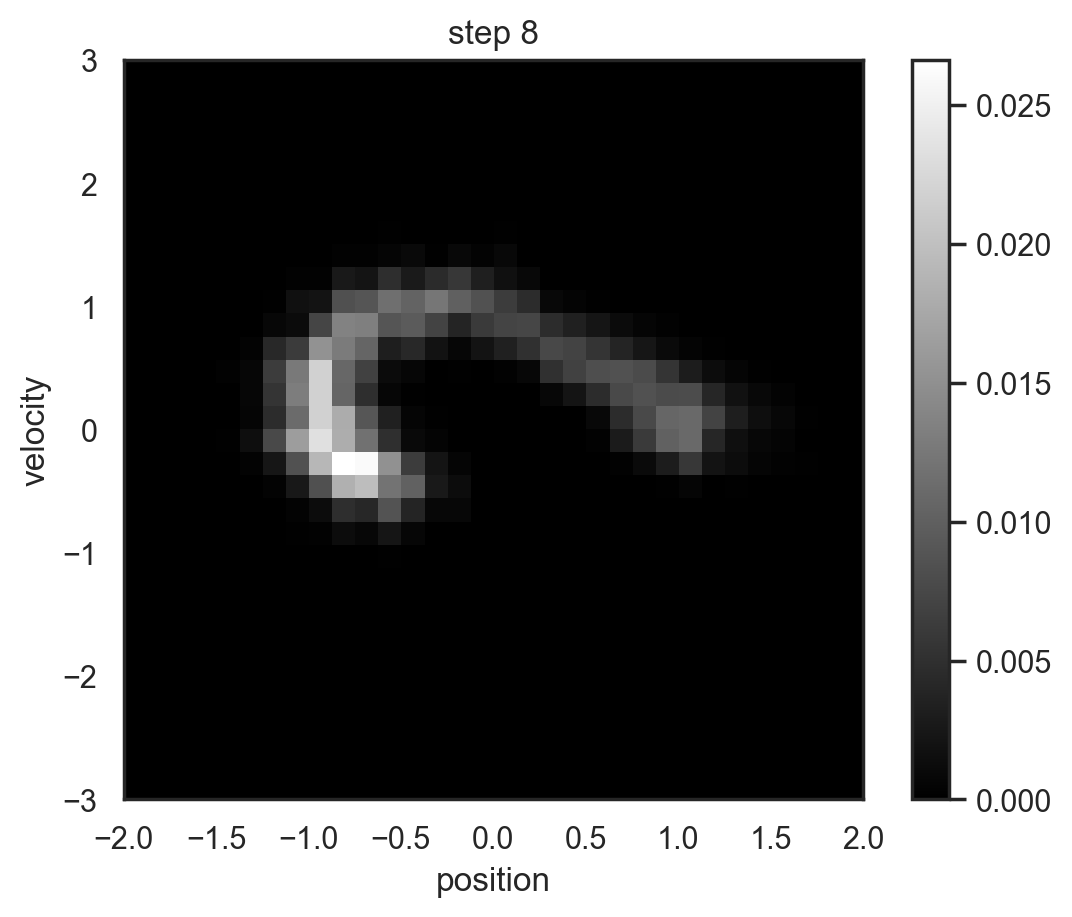

In [55]:
idx_act = 2

starting_motion = np.array([1.0, 0.0])

belief = np.zeros(n_state)
dist, idx = tree.query(starting_motion)
belief[idx] = 1

step = 0
for step in range(n_steps_variations[-1]+1):

    belief = np.dot(p_backward[idx_act], belief)

    plot_belief(belief)
    plt.title(f"step {step}")
    step += 1